In [1]:
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Users\HH TRADERS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('../data/train.csv')
train.sort_values(by=['class', 'image'])
train.tail()

,image,class
13017,winKen_wave_u_cm_np1_ri_bad_1_frame0.jpg,wave
13018,winKen_wave_u_cm_np1_ri_bad_1_frame1.jpg,wave
13019,winKen_wave_u_cm_np1_ri_bad_1_frame2.jpg,wave
13020,winKen_wave_u_cm_np1_ri_bad_1_frame3.jpg,wave
13021,winKen_wave_u_cm_np1_ri_bad_1_frame4.jpg,wave


In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/train_frame/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)

100%|██████████| 13022/13022 [01:26<00:00, 149.89it/s]


In [4]:
# converting the list to numpy array
X_train = np.array(train_image,np.float16)

# shape of the array
X_train.shape

(13022, 224, 224, 3)

In [5]:
val = pd.read_csv('../data/val.csv')
val.sort_values(by=['class', 'image'])
val.tail()

,image,class
5504,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5505,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5506,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5507,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave
5508,prelinger_LetsBeGo1953_wave_u_cm_np10_ba_med_3...,wave


In [6]:
# creating an empty list
val_image = []

# for loop to read and store frames
for i in tqdm(range(val.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('../data/val_frame/'+val['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    val_image.append(img)

100%|██████████| 5509/5509 [00:43<00:00, 127.36it/s]


In [7]:
# converting the list to numpy array
X_test = np.array(val_image,np.float16)

# shape of the array
X_test.shape

(5509, 224, 224, 3)

In [8]:
# separating the target
y_train = train['class']
y_test = val['class']
print(y_train.shape)
print(y_test.shape)
train.nunique()
val.nunique()

(13022,)
(5509,)


image    5509
class      51
dtype: int64

In [9]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
print(y_train.shape)
print(y_test.shape)

(13022, 51)
(5509, 51)


In [10]:
# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)

In [11]:
print(base_model.output_shape)

(None, None, None, 512)


In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [13]:
base_model.get_config()

{'name': 'vgg16',
 'layers': [{'name': 'input_1',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, None, 3),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_1'},
   'inbound_nodes': []},
  {'name': 'block1_conv1',
   'class_name': 'Conv2D',
   'config': {'name': 'block1_conv1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 64,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'inbound_nodes': [[['input_1',

In [14]:
base_model.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431

In [15]:
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape

(13022, 7, 7, 512)

In [16]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

(5509, 7, 7, 512)

In [17]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(13022, 7*7*512)
X_test = X_test.reshape(5509, 7*7*512)

In [18]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

In [19]:
# Save the model as a pickle in a file 
joblib.dump(X_train, '../Pickle/VGG16_X_train.pkl') 
joblib.dump(X_test, '../Pickle/VGG16_X_test.pkl')

['../Pickle/VGG16_X_test.pkl']

In [20]:
# Load the model from the file 
X_train = joblib.load('../Pickle/VGG16_X_train.pkl') 
X_test = joblib.load('../Pickle/VGG16_X_test.pkl') 

In [21]:
# shape of images
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13022, 25088)
(5509, 25088)
(13022, 51)
(5509, 51)


In [22]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(51, activation='softmax'))

In [23]:
model.output_shape

(None, 51)

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [25]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 25088),
    'dtype': 'float32',
    'units': 1024,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_1',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.5,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 512,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initi

In [26]:
model.get_weights()

[array([[-0.00909883,  0.01415055, -0.01279868, ..., -0.01203952,
          0.0145464 ,  0.00038882],
        [ 0.00112038, -0.01225226, -0.01349978, ..., -0.01459981,
          0.00526624,  0.01483781],
        [ 0.00497044,  0.00749006,  0.00717427, ...,  0.01394898,
         -0.01151245, -0.01038418],
        ...,
        [ 0.01290878, -0.01226488,  0.01196846, ...,  0.00210151,
         -0.00119754,  0.00828971],
        [-0.00867657, -0.00750123,  0.00421396, ...,  0.00364621,
          0.00171949,  0.0147988 ],
        [ 0.01022565, -0.01120348,  0.00402174, ...,  0.0146241 ,
         -0.00131805,  0.01241883]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([[-0.04713827,  0.02823399,  0.0080025 , ..., -0.04757001,
          0.01633804,  0.05321115],
        [-0.0211924 ,  0.03803627, -0.0083179 , ...,  0.03062811,
         -0.05884844, -0.05671798],
        [-0.01071872,  0.02267216,  0.01872021, ...,  0.0151929 ,
          0.0089132 , -0.03520648]

In [27]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('../Models/weightVGG16.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [28]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [29]:
# training the model
history=model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Train on 13022 samples, validate on 5509 samples
Epoch 1/100
13022/13022 [==============================] - ETA: 2:00 - loss: 3.9318 - accuracy: 0.01 - ETA: 1:14 - loss: 3.9630 - accuracy: 0.01 - ETA: 58s - loss: 3.9864 - accuracy: 0.0156 - ETA: 50s - loss: 3.9980 - accuracy: 0.017 - ETA: 45s - loss: 3.9970 - accuracy: 0.017 - ETA: 42s - loss: 4.0147 - accuracy: 0.016 - ETA: 40s - loss: 4.0258 - accuracy: 0.017 - ETA: 37s - loss: 4.0314 - accuracy: 0.015 - ETA: 36s - loss: 4.0357 - accuracy: 0.016 - ETA: 35s - loss: 4.0291 - accuracy: 0.018 - ETA: 34s - loss: 4.0327 - accuracy: 0.019 - ETA: 32s - loss: 4.0294 - accuracy: 0.019 - ETA: 32s - loss: 4.0214 - accuracy: 0.021 - ETA: 31s - loss: 4.0173 - accuracy: 0.020 - ETA: 30s - loss: 4.0160 - accuracy: 0.022 - ETA: 29s - loss: 4.0166 - accuracy: 0.022 - ETA: 29s - loss: 4.0136 - accuracy: 0.022 - ETA: 28s - loss: 4.0105 - accuracy: 0.022 - ETA: 28s - loss: 4.0099 - accuracy: 0.022 - ETA: 27s - loss: 4.0070 - accuracy: 0.023 - ETA: 27s - 

13022/13022 [==============================] - ETA: 27s - loss: 3.7543 - accuracy: 0.078 - ETA: 29s - loss: 3.8289 - accuracy: 0.058 - ETA: 29s - loss: 3.8171 - accuracy: 0.052 - ETA: 28s - loss: 3.8010 - accuracy: 0.056 - ETA: 28s - loss: 3.7876 - accuracy: 0.056 - ETA: 28s - loss: 3.7803 - accuracy: 0.056 - ETA: 27s - loss: 3.7794 - accuracy: 0.054 - ETA: 27s - loss: 3.7771 - accuracy: 0.056 - ETA: 27s - loss: 3.7806 - accuracy: 0.055 - ETA: 26s - loss: 3.7855 - accuracy: 0.052 - ETA: 26s - loss: 3.7855 - accuracy: 0.052 - ETA: 26s - loss: 3.7796 - accuracy: 0.054 - ETA: 25s - loss: 3.7726 - accuracy: 0.054 - ETA: 25s - loss: 3.7697 - accuracy: 0.055 - ETA: 25s - loss: 3.7733 - accuracy: 0.055 - ETA: 25s - loss: 3.7727 - accuracy: 0.055 - ETA: 24s - loss: 3.7665 - accuracy: 0.057 - ETA: 24s - loss: 3.7645 - accuracy: 0.056 - ETA: 24s - loss: 3.7598 - accuracy: 0.054 - ETA: 24s - loss: 3.7582 - accuracy: 0.054 - ETA: 24s - loss: 3.7574 - accuracy: 0.054 - ETA: 23s - loss: 3.7550 - acc

13022/13022 [==============================] - ETA: 28s - loss: 3.4150 - accuracy: 0.132 - ETA: 28s - loss: 3.4577 - accuracy: 0.117 - ETA: 27s - loss: 3.4767 - accuracy: 0.117 - ETA: 28s - loss: 3.4893 - accuracy: 0.115 - ETA: 28s - loss: 3.4697 - accuracy: 0.118 - ETA: 28s - loss: 3.4677 - accuracy: 0.122 - ETA: 28s - loss: 3.4367 - accuracy: 0.130 - ETA: 27s - loss: 3.4332 - accuracy: 0.129 - ETA: 27s - loss: 3.4284 - accuracy: 0.131 - ETA: 27s - loss: 3.4280 - accuracy: 0.130 - ETA: 27s - loss: 3.4253 - accuracy: 0.130 - ETA: 27s - loss: 3.4148 - accuracy: 0.132 - ETA: 26s - loss: 3.4143 - accuracy: 0.134 - ETA: 26s - loss: 3.4018 - accuracy: 0.136 - ETA: 26s - loss: 3.4070 - accuracy: 0.134 - ETA: 25s - loss: 3.4089 - accuracy: 0.133 - ETA: 25s - loss: 3.4027 - accuracy: 0.136 - ETA: 25s - loss: 3.4046 - accuracy: 0.136 - ETA: 25s - loss: 3.4052 - accuracy: 0.136 - ETA: 24s - loss: 3.4012 - accuracy: 0.137 - ETA: 24s - loss: 3.3957 - accuracy: 0.138 - ETA: 24s - loss: 3.3940 - acc

13022/13022 [==============================] - ETA: 27s - loss: 2.9477 - accuracy: 0.250 - ETA: 28s - loss: 3.0572 - accuracy: 0.207 - ETA: 28s - loss: 3.1093 - accuracy: 0.190 - ETA: 28s - loss: 3.1124 - accuracy: 0.189 - ETA: 28s - loss: 3.1183 - accuracy: 0.182 - ETA: 27s - loss: 3.1098 - accuracy: 0.187 - ETA: 27s - loss: 3.0978 - accuracy: 0.187 - ETA: 27s - loss: 3.0812 - accuracy: 0.194 - ETA: 26s - loss: 3.0468 - accuracy: 0.203 - ETA: 26s - loss: 3.0414 - accuracy: 0.204 - ETA: 26s - loss: 3.0485 - accuracy: 0.201 - ETA: 26s - loss: 3.0532 - accuracy: 0.198 - ETA: 25s - loss: 3.0419 - accuracy: 0.201 - ETA: 25s - loss: 3.0401 - accuracy: 0.204 - ETA: 25s - loss: 3.0438 - accuracy: 0.204 - ETA: 24s - loss: 3.0420 - accuracy: 0.206 - ETA: 24s - loss: 3.0352 - accuracy: 0.206 - ETA: 24s - loss: 3.0398 - accuracy: 0.205 - ETA: 24s - loss: 3.0370 - accuracy: 0.205 - ETA: 23s - loss: 3.0380 - accuracy: 0.206 - ETA: 23s - loss: 3.0345 - accuracy: 0.206 - ETA: 23s - loss: 3.0389 - acc

13022/13022 [==============================] - ETA: 29s - loss: 2.8178 - accuracy: 0.257 - ETA: 29s - loss: 2.7460 - accuracy: 0.257 - ETA: 29s - loss: 2.7472 - accuracy: 0.268 - ETA: 29s - loss: 2.6911 - accuracy: 0.275 - ETA: 28s - loss: 2.7038 - accuracy: 0.268 - ETA: 28s - loss: 2.6924 - accuracy: 0.270 - ETA: 28s - loss: 2.6926 - accuracy: 0.273 - ETA: 27s - loss: 2.6907 - accuracy: 0.275 - ETA: 27s - loss: 2.7146 - accuracy: 0.270 - ETA: 26s - loss: 2.7439 - accuracy: 0.261 - ETA: 26s - loss: 2.7427 - accuracy: 0.259 - ETA: 26s - loss: 2.7462 - accuracy: 0.261 - ETA: 26s - loss: 2.7516 - accuracy: 0.264 - ETA: 25s - loss: 2.7721 - accuracy: 0.260 - ETA: 25s - loss: 2.7783 - accuracy: 0.259 - ETA: 25s - loss: 2.7752 - accuracy: 0.262 - ETA: 24s - loss: 2.7853 - accuracy: 0.259 - ETA: 24s - loss: 2.7944 - accuracy: 0.256 - ETA: 24s - loss: 2.8006 - accuracy: 0.252 - ETA: 24s - loss: 2.8117 - accuracy: 0.250 - ETA: 23s - loss: 2.8157 - accuracy: 0.251 - ETA: 23s - loss: 2.8138 - acc

13022/13022 [==============================] - ETA: 29s - loss: 2.5728 - accuracy: 0.273 - ETA: 28s - loss: 2.5562 - accuracy: 0.296 - ETA: 28s - loss: 2.6221 - accuracy: 0.294 - ETA: 27s - loss: 2.6593 - accuracy: 0.287 - ETA: 27s - loss: 2.6572 - accuracy: 0.282 - ETA: 27s - loss: 2.6615 - accuracy: 0.285 - ETA: 27s - loss: 2.6307 - accuracy: 0.291 - ETA: 27s - loss: 2.6413 - accuracy: 0.287 - ETA: 26s - loss: 2.6645 - accuracy: 0.283 - ETA: 26s - loss: 2.6564 - accuracy: 0.285 - ETA: 26s - loss: 2.6480 - accuracy: 0.284 - ETA: 25s - loss: 2.6387 - accuracy: 0.285 - ETA: 25s - loss: 2.6474 - accuracy: 0.280 - ETA: 25s - loss: 2.6328 - accuracy: 0.280 - ETA: 24s - loss: 2.6535 - accuracy: 0.278 - ETA: 24s - loss: 2.6598 - accuracy: 0.277 - ETA: 24s - loss: 2.6582 - accuracy: 0.276 - ETA: 24s - loss: 2.6652 - accuracy: 0.273 - ETA: 24s - loss: 2.6547 - accuracy: 0.276 - ETA: 23s - loss: 2.6575 - accuracy: 0.275 - ETA: 23s - loss: 2.6561 - accuracy: 0.274 - ETA: 23s - loss: 2.6587 - acc

13022/13022 [==============================] - ETA: 26s - loss: 2.5364 - accuracy: 0.296 - ETA: 29s - loss: 2.6026 - accuracy: 0.300 - ETA: 27s - loss: 2.6125 - accuracy: 0.278 - ETA: 28s - loss: 2.5916 - accuracy: 0.285 - ETA: 28s - loss: 2.5971 - accuracy: 0.289 - ETA: 27s - loss: 2.5756 - accuracy: 0.285 - ETA: 27s - loss: 2.5698 - accuracy: 0.284 - ETA: 27s - loss: 2.5547 - accuracy: 0.289 - ETA: 27s - loss: 2.5531 - accuracy: 0.290 - ETA: 26s - loss: 2.5403 - accuracy: 0.295 - ETA: 26s - loss: 2.5334 - accuracy: 0.299 - ETA: 26s - loss: 2.5226 - accuracy: 0.304 - ETA: 26s - loss: 2.5270 - accuracy: 0.305 - ETA: 25s - loss: 2.5009 - accuracy: 0.315 - ETA: 25s - loss: 2.4880 - accuracy: 0.317 - ETA: 25s - loss: 2.4910 - accuracy: 0.317 - ETA: 25s - loss: 2.4763 - accuracy: 0.322 - ETA: 24s - loss: 2.4768 - accuracy: 0.319 - ETA: 24s - loss: 2.4704 - accuracy: 0.322 - ETA: 24s - loss: 2.4563 - accuracy: 0.327 - ETA: 24s - loss: 2.4609 - accuracy: 0.324 - ETA: 23s - loss: 2.4626 - acc

13022/13022 [==============================] - ETA: 28s - loss: 2.4590 - accuracy: 0.296 - ETA: 29s - loss: 2.4262 - accuracy: 0.316 - ETA: 28s - loss: 2.3647 - accuracy: 0.335 - ETA: 27s - loss: 2.3399 - accuracy: 0.347 - ETA: 27s - loss: 2.3307 - accuracy: 0.345 - ETA: 27s - loss: 2.3130 - accuracy: 0.349 - ETA: 27s - loss: 2.2906 - accuracy: 0.351 - ETA: 26s - loss: 2.2897 - accuracy: 0.352 - ETA: 26s - loss: 2.3140 - accuracy: 0.346 - ETA: 26s - loss: 2.3155 - accuracy: 0.343 - ETA: 26s - loss: 2.3088 - accuracy: 0.347 - ETA: 26s - loss: 2.3093 - accuracy: 0.347 - ETA: 25s - loss: 2.2959 - accuracy: 0.351 - ETA: 25s - loss: 2.3022 - accuracy: 0.351 - ETA: 25s - loss: 2.3058 - accuracy: 0.350 - ETA: 25s - loss: 2.3100 - accuracy: 0.348 - ETA: 24s - loss: 2.3073 - accuracy: 0.350 - ETA: 24s - loss: 2.3149 - accuracy: 0.348 - ETA: 24s - loss: 2.3075 - accuracy: 0.351 - ETA: 23s - loss: 2.3084 - accuracy: 0.348 - ETA: 23s - loss: 2.3073 - accuracy: 0.349 - ETA: 23s - loss: 2.3080 - acc

13022/13022 [==============================] - ETA: 29s - loss: 2.3850 - accuracy: 0.343 - ETA: 28s - loss: 2.3064 - accuracy: 0.320 - ETA: 28s - loss: 2.2576 - accuracy: 0.330 - ETA: 28s - loss: 2.2874 - accuracy: 0.332 - ETA: 28s - loss: 2.2516 - accuracy: 0.346 - ETA: 28s - loss: 2.2010 - accuracy: 0.356 - ETA: 28s - loss: 2.2514 - accuracy: 0.342 - ETA: 28s - loss: 2.2292 - accuracy: 0.343 - ETA: 28s - loss: 2.1942 - accuracy: 0.359 - ETA: 28s - loss: 2.1910 - accuracy: 0.360 - ETA: 28s - loss: 2.2071 - accuracy: 0.358 - ETA: 27s - loss: 2.2173 - accuracy: 0.360 - ETA: 27s - loss: 2.2125 - accuracy: 0.361 - ETA: 27s - loss: 2.2096 - accuracy: 0.364 - ETA: 27s - loss: 2.2204 - accuracy: 0.361 - ETA: 26s - loss: 2.2172 - accuracy: 0.366 - ETA: 26s - loss: 2.2348 - accuracy: 0.361 - ETA: 26s - loss: 2.2458 - accuracy: 0.358 - ETA: 25s - loss: 2.2456 - accuracy: 0.358 - ETA: 25s - loss: 2.2415 - accuracy: 0.360 - ETA: 25s - loss: 2.2274 - accuracy: 0.363 - ETA: 24s - loss: 2.2315 - acc

13022/13022 [==============================] - ETA: 29s - loss: 2.0513 - accuracy: 0.382 - ETA: 28s - loss: 2.1742 - accuracy: 0.355 - ETA: 29s - loss: 2.0917 - accuracy: 0.385 - ETA: 29s - loss: 2.0736 - accuracy: 0.398 - ETA: 30s - loss: 2.0639 - accuracy: 0.398 - ETA: 30s - loss: 2.0927 - accuracy: 0.391 - ETA: 29s - loss: 2.0835 - accuracy: 0.399 - ETA: 29s - loss: 2.0850 - accuracy: 0.400 - ETA: 28s - loss: 2.0658 - accuracy: 0.410 - ETA: 28s - loss: 2.0728 - accuracy: 0.409 - ETA: 27s - loss: 2.0812 - accuracy: 0.402 - ETA: 27s - loss: 2.0847 - accuracy: 0.403 - ETA: 27s - loss: 2.0849 - accuracy: 0.402 - ETA: 26s - loss: 2.0952 - accuracy: 0.399 - ETA: 26s - loss: 2.1086 - accuracy: 0.395 - ETA: 26s - loss: 2.1098 - accuracy: 0.396 - ETA: 26s - loss: 2.1151 - accuracy: 0.396 - ETA: 26s - loss: 2.1223 - accuracy: 0.393 - ETA: 25s - loss: 2.1320 - accuracy: 0.393 - ETA: 25s - loss: 2.1290 - accuracy: 0.396 - ETA: 25s - loss: 2.1412 - accuracy: 0.392 - ETA: 25s - loss: 2.1402 - acc

13022/13022 [==============================] - ETA: 28s - loss: 2.0524 - accuracy: 0.406 - ETA: 28s - loss: 2.0973 - accuracy: 0.382 - ETA: 28s - loss: 2.0773 - accuracy: 0.390 - ETA: 28s - loss: 2.0054 - accuracy: 0.419 - ETA: 28s - loss: 2.0068 - accuracy: 0.414 - ETA: 28s - loss: 1.9827 - accuracy: 0.425 - ETA: 28s - loss: 2.0050 - accuracy: 0.419 - ETA: 27s - loss: 2.0053 - accuracy: 0.421 - ETA: 27s - loss: 2.0315 - accuracy: 0.411 - ETA: 27s - loss: 2.0466 - accuracy: 0.405 - ETA: 27s - loss: 2.0544 - accuracy: 0.400 - ETA: 26s - loss: 2.0580 - accuracy: 0.401 - ETA: 26s - loss: 2.0464 - accuracy: 0.406 - ETA: 26s - loss: 2.0397 - accuracy: 0.409 - ETA: 25s - loss: 2.0550 - accuracy: 0.405 - ETA: 25s - loss: 2.0553 - accuracy: 0.403 - ETA: 25s - loss: 2.0620 - accuracy: 0.401 - ETA: 25s - loss: 2.0622 - accuracy: 0.403 - ETA: 24s - loss: 2.0434 - accuracy: 0.406 - ETA: 24s - loss: 2.0416 - accuracy: 0.408 - ETA: 24s - loss: 2.0526 - accuracy: 0.403 - ETA: 24s - loss: 2.0613 - acc

13022/13022 [==============================] - ETA: 29s - loss: 1.9702 - accuracy: 0.421 - ETA: 28s - loss: 2.0286 - accuracy: 0.410 - ETA: 28s - loss: 1.9588 - accuracy: 0.421 - ETA: 28s - loss: 1.9409 - accuracy: 0.433 - ETA: 27s - loss: 1.9151 - accuracy: 0.442 - ETA: 27s - loss: 1.9343 - accuracy: 0.442 - ETA: 27s - loss: 1.9429 - accuracy: 0.436 - ETA: 27s - loss: 1.9604 - accuracy: 0.429 - ETA: 26s - loss: 1.9488 - accuracy: 0.431 - ETA: 26s - loss: 1.9286 - accuracy: 0.433 - ETA: 26s - loss: 1.9391 - accuracy: 0.429 - ETA: 25s - loss: 1.9373 - accuracy: 0.429 - ETA: 25s - loss: 1.9323 - accuracy: 0.430 - ETA: 25s - loss: 1.9269 - accuracy: 0.433 - ETA: 25s - loss: 1.9357 - accuracy: 0.429 - ETA: 24s - loss: 1.9321 - accuracy: 0.427 - ETA: 24s - loss: 1.9181 - accuracy: 0.433 - ETA: 24s - loss: 1.9190 - accuracy: 0.430 - ETA: 23s - loss: 1.9174 - accuracy: 0.428 - ETA: 23s - loss: 1.9202 - accuracy: 0.429 - ETA: 23s - loss: 1.9171 - accuracy: 0.430 - ETA: 23s - loss: 1.9349 - acc

13022/13022 [==============================] - ETA: 30s - loss: 2.1091 - accuracy: 0.390 - ETA: 30s - loss: 2.0099 - accuracy: 0.394 - ETA: 29s - loss: 2.0098 - accuracy: 0.395 - ETA: 29s - loss: 1.9906 - accuracy: 0.412 - ETA: 28s - loss: 1.9972 - accuracy: 0.403 - ETA: 28s - loss: 1.9915 - accuracy: 0.408 - ETA: 28s - loss: 1.9885 - accuracy: 0.404 - ETA: 28s - loss: 1.9865 - accuracy: 0.401 - ETA: 27s - loss: 1.9902 - accuracy: 0.405 - ETA: 27s - loss: 1.9840 - accuracy: 0.408 - ETA: 27s - loss: 1.9849 - accuracy: 0.411 - ETA: 26s - loss: 1.9742 - accuracy: 0.415 - ETA: 26s - loss: 1.9641 - accuracy: 0.422 - ETA: 26s - loss: 1.9454 - accuracy: 0.425 - ETA: 25s - loss: 1.9459 - accuracy: 0.422 - ETA: 25s - loss: 1.9542 - accuracy: 0.418 - ETA: 25s - loss: 1.9469 - accuracy: 0.421 - ETA: 25s - loss: 1.9621 - accuracy: 0.418 - ETA: 24s - loss: 1.9462 - accuracy: 0.423 - ETA: 24s - loss: 1.9456 - accuracy: 0.424 - ETA: 24s - loss: 1.9589 - accuracy: 0.421 - ETA: 23s - loss: 1.9597 - acc

13022/13022 [==============================] - ETA: 27s - loss: 1.9389 - accuracy: 0.453 - ETA: 27s - loss: 1.8782 - accuracy: 0.476 - ETA: 28s - loss: 1.8544 - accuracy: 0.466 - ETA: 28s - loss: 1.8617 - accuracy: 0.451 - ETA: 28s - loss: 1.8992 - accuracy: 0.440 - ETA: 27s - loss: 1.8930 - accuracy: 0.440 - ETA: 27s - loss: 1.8937 - accuracy: 0.440 - ETA: 27s - loss: 1.8814 - accuracy: 0.445 - ETA: 27s - loss: 1.8629 - accuracy: 0.452 - ETA: 27s - loss: 1.8909 - accuracy: 0.446 - ETA: 27s - loss: 1.8944 - accuracy: 0.443 - ETA: 26s - loss: 1.8919 - accuracy: 0.442 - ETA: 26s - loss: 1.8810 - accuracy: 0.445 - ETA: 26s - loss: 1.8563 - accuracy: 0.451 - ETA: 25s - loss: 1.8611 - accuracy: 0.450 - ETA: 25s - loss: 1.8551 - accuracy: 0.449 - ETA: 25s - loss: 1.8533 - accuracy: 0.449 - ETA: 25s - loss: 1.8471 - accuracy: 0.453 - ETA: 25s - loss: 1.8443 - accuracy: 0.451 - ETA: 25s - loss: 1.8472 - accuracy: 0.447 - ETA: 24s - loss: 1.8463 - accuracy: 0.447 - ETA: 24s - loss: 1.8609 - acc

13022/13022 [==============================] - ETA: 32s - loss: 2.0806 - accuracy: 0.367 - ETA: 29s - loss: 1.9567 - accuracy: 0.418 - ETA: 29s - loss: 1.8049 - accuracy: 0.463 - ETA: 29s - loss: 1.8528 - accuracy: 0.447 - ETA: 29s - loss: 1.8313 - accuracy: 0.456 - ETA: 29s - loss: 1.8177 - accuracy: 0.455 - ETA: 29s - loss: 1.8050 - accuracy: 0.457 - ETA: 28s - loss: 1.8088 - accuracy: 0.458 - ETA: 28s - loss: 1.8214 - accuracy: 0.452 - ETA: 28s - loss: 1.8194 - accuracy: 0.453 - ETA: 28s - loss: 1.8139 - accuracy: 0.453 - ETA: 27s - loss: 1.8363 - accuracy: 0.447 - ETA: 27s - loss: 1.8468 - accuracy: 0.447 - ETA: 27s - loss: 1.8501 - accuracy: 0.448 - ETA: 26s - loss: 1.8444 - accuracy: 0.450 - ETA: 26s - loss: 1.8345 - accuracy: 0.452 - ETA: 26s - loss: 1.8291 - accuracy: 0.453 - ETA: 25s - loss: 1.8343 - accuracy: 0.454 - ETA: 25s - loss: 1.8446 - accuracy: 0.453 - ETA: 25s - loss: 1.8347 - accuracy: 0.456 - ETA: 24s - loss: 1.8370 - accuracy: 0.456 - ETA: 24s - loss: 1.8327 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.7026 - accuracy: 0.476 - ETA: 55s - loss: 1.6548 - accuracy: 0.492 - ETA: 52s - loss: 1.6823 - accuracy: 0.502 - ETA: 52s - loss: 1.6815 - accuracy: 0.509 - ETA: 52s - loss: 1.6977 - accuracy: 0.512 - ETA: 52s - loss: 1.6989 - accuracy: 0.507 - ETA: 51s - loss: 1.7174 - accuracy: 0.497 - ETA: 51s - loss: 1.7701 - accuracy: 0.479 - ETA: 50s - loss: 1.7742 - accuracy: 0.475 - ETA: 49s - loss: 1.7767 - accuracy: 0.473 - ETA: 49s - loss: 1.7966 - accuracy: 0.468 - ETA: 48s - loss: 1.8011 - accuracy: 0.466 - ETA: 46s - loss: 1.8192 - accuracy: 0.463 - ETA: 45s - loss: 1.8343 - accuracy: 0.456 - ETA: 43s - loss: 1.8364 - accuracy: 0.458 - ETA: 42s - loss: 1.8291 - accuracy: 0.460 - ETA: 41s - loss: 1.8323 - accuracy: 0.460 - ETA: 40s - loss: 1.8337 - accuracy: 0.459 - ETA: 40s - loss: 1.8230 - accuracy: 0.463 - ETA: 39s - loss: 1.8306 - accuracy: 0.459 - ETA: 38s - loss: 1.8273 - accuracy: 0.459 - ETA: 38s - loss: 1.8212 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.5677 - accuracy: 0.515 - ETA: 47s - loss: 1.5305 - accuracy: 0.523 - ETA: 47s - loss: 1.6428 - accuracy: 0.500 - ETA: 46s - loss: 1.6863 - accuracy: 0.490 - ETA: 46s - loss: 1.6765 - accuracy: 0.485 - ETA: 46s - loss: 1.6729 - accuracy: 0.490 - ETA: 46s - loss: 1.7010 - accuracy: 0.493 - ETA: 45s - loss: 1.7095 - accuracy: 0.493 - ETA: 45s - loss: 1.6848 - accuracy: 0.499 - ETA: 45s - loss: 1.6963 - accuracy: 0.498 - ETA: 44s - loss: 1.7084 - accuracy: 0.490 - ETA: 43s - loss: 1.7448 - accuracy: 0.480 - ETA: 43s - loss: 1.7318 - accuracy: 0.482 - ETA: 42s - loss: 1.7342 - accuracy: 0.481 - ETA: 42s - loss: 1.7237 - accuracy: 0.483 - ETA: 41s - loss: 1.7151 - accuracy: 0.486 - ETA: 41s - loss: 1.7107 - accuracy: 0.487 - ETA: 40s - loss: 1.7032 - accuracy: 0.487 - ETA: 40s - loss: 1.7025 - accuracy: 0.485 - ETA: 39s - loss: 1.7114 - accuracy: 0.482 - ETA: 39s - loss: 1.7234 - accuracy: 0.481 - ETA: 38s - loss: 1.7238 - acc

13022/13022 [==============================] - ETA: 49s - loss: 1.5750 - accuracy: 0.523 - ETA: 47s - loss: 1.6024 - accuracy: 0.539 - ETA: 46s - loss: 1.6001 - accuracy: 0.531 - ETA: 46s - loss: 1.6122 - accuracy: 0.517 - ETA: 45s - loss: 1.6437 - accuracy: 0.520 - ETA: 44s - loss: 1.6734 - accuracy: 0.514 - ETA: 44s - loss: 1.6642 - accuracy: 0.511 - ETA: 44s - loss: 1.6674 - accuracy: 0.509 - ETA: 43s - loss: 1.6779 - accuracy: 0.499 - ETA: 43s - loss: 1.6908 - accuracy: 0.491 - ETA: 42s - loss: 1.6760 - accuracy: 0.496 - ETA: 42s - loss: 1.6667 - accuracy: 0.500 - ETA: 42s - loss: 1.6680 - accuracy: 0.497 - ETA: 41s - loss: 1.6927 - accuracy: 0.490 - ETA: 41s - loss: 1.6958 - accuracy: 0.489 - ETA: 40s - loss: 1.7154 - accuracy: 0.485 - ETA: 39s - loss: 1.7036 - accuracy: 0.490 - ETA: 39s - loss: 1.7007 - accuracy: 0.490 - ETA: 39s - loss: 1.7024 - accuracy: 0.491 - ETA: 38s - loss: 1.7115 - accuracy: 0.489 - ETA: 38s - loss: 1.7147 - accuracy: 0.488 - ETA: 37s - loss: 1.7347 - acc

13022/13022 [==============================] - ETA: 46s - loss: 1.6395 - accuracy: 0.539 - ETA: 46s - loss: 1.7578 - accuracy: 0.519 - ETA: 45s - loss: 1.7689 - accuracy: 0.513 - ETA: 45s - loss: 1.6912 - accuracy: 0.525 - ETA: 44s - loss: 1.6954 - accuracy: 0.518 - ETA: 44s - loss: 1.6801 - accuracy: 0.510 - ETA: 44s - loss: 1.6679 - accuracy: 0.512 - ETA: 43s - loss: 1.6605 - accuracy: 0.510 - ETA: 42s - loss: 1.6525 - accuracy: 0.509 - ETA: 42s - loss: 1.6505 - accuracy: 0.507 - ETA: 41s - loss: 1.6650 - accuracy: 0.504 - ETA: 41s - loss: 1.6663 - accuracy: 0.505 - ETA: 40s - loss: 1.6640 - accuracy: 0.508 - ETA: 40s - loss: 1.6585 - accuracy: 0.507 - ETA: 40s - loss: 1.6780 - accuracy: 0.503 - ETA: 39s - loss: 1.6848 - accuracy: 0.499 - ETA: 39s - loss: 1.6884 - accuracy: 0.499 - ETA: 38s - loss: 1.6809 - accuracy: 0.498 - ETA: 38s - loss: 1.6886 - accuracy: 0.497 - ETA: 37s - loss: 1.6920 - accuracy: 0.495 - ETA: 37s - loss: 1.6928 - accuracy: 0.494 - ETA: 36s - loss: 1.7013 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.6697 - accuracy: 0.515 - ETA: 48s - loss: 1.7386 - accuracy: 0.503 - ETA: 48s - loss: 1.6850 - accuracy: 0.502 - ETA: 46s - loss: 1.7055 - accuracy: 0.502 - ETA: 46s - loss: 1.7097 - accuracy: 0.489 - ETA: 45s - loss: 1.6718 - accuracy: 0.497 - ETA: 44s - loss: 1.6835 - accuracy: 0.500 - ETA: 44s - loss: 1.6881 - accuracy: 0.495 - ETA: 43s - loss: 1.6970 - accuracy: 0.497 - ETA: 43s - loss: 1.7020 - accuracy: 0.495 - ETA: 42s - loss: 1.6886 - accuracy: 0.496 - ETA: 42s - loss: 1.7155 - accuracy: 0.490 - ETA: 41s - loss: 1.7091 - accuracy: 0.491 - ETA: 41s - loss: 1.7218 - accuracy: 0.486 - ETA: 40s - loss: 1.7059 - accuracy: 0.491 - ETA: 40s - loss: 1.7068 - accuracy: 0.489 - ETA: 39s - loss: 1.6972 - accuracy: 0.494 - ETA: 39s - loss: 1.6891 - accuracy: 0.496 - ETA: 39s - loss: 1.6831 - accuracy: 0.496 - ETA: 38s - loss: 1.6773 - accuracy: 0.495 - ETA: 38s - loss: 1.6650 - accuracy: 0.501 - ETA: 37s - loss: 1.6719 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.8407 - accuracy: 0.445 - ETA: 50s - loss: 1.6892 - accuracy: 0.480 - ETA: 49s - loss: 1.7092 - accuracy: 0.474 - ETA: 47s - loss: 1.7044 - accuracy: 0.484 - ETA: 46s - loss: 1.6970 - accuracy: 0.484 - ETA: 45s - loss: 1.6831 - accuracy: 0.484 - ETA: 44s - loss: 1.7031 - accuracy: 0.477 - ETA: 44s - loss: 1.7032 - accuracy: 0.479 - ETA: 44s - loss: 1.6786 - accuracy: 0.484 - ETA: 43s - loss: 1.6864 - accuracy: 0.483 - ETA: 43s - loss: 1.6998 - accuracy: 0.480 - ETA: 42s - loss: 1.7051 - accuracy: 0.481 - ETA: 41s - loss: 1.6858 - accuracy: 0.484 - ETA: 41s - loss: 1.6892 - accuracy: 0.487 - ETA: 40s - loss: 1.6864 - accuracy: 0.488 - ETA: 40s - loss: 1.6819 - accuracy: 0.487 - ETA: 39s - loss: 1.6805 - accuracy: 0.488 - ETA: 39s - loss: 1.6770 - accuracy: 0.488 - ETA: 38s - loss: 1.6806 - accuracy: 0.488 - ETA: 38s - loss: 1.6864 - accuracy: 0.487 - ETA: 37s - loss: 1.6941 - accuracy: 0.485 - ETA: 37s - loss: 1.6891 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.6030 - accuracy: 0.500 - ETA: 48s - loss: 1.6337 - accuracy: 0.503 - ETA: 47s - loss: 1.6068 - accuracy: 0.523 - ETA: 46s - loss: 1.6145 - accuracy: 0.513 - ETA: 45s - loss: 1.6420 - accuracy: 0.503 - ETA: 44s - loss: 1.6051 - accuracy: 0.518 - ETA: 44s - loss: 1.6179 - accuracy: 0.507 - ETA: 43s - loss: 1.6093 - accuracy: 0.511 - ETA: 43s - loss: 1.6163 - accuracy: 0.514 - ETA: 43s - loss: 1.6123 - accuracy: 0.518 - ETA: 42s - loss: 1.6089 - accuracy: 0.517 - ETA: 41s - loss: 1.6253 - accuracy: 0.516 - ETA: 41s - loss: 1.6203 - accuracy: 0.515 - ETA: 41s - loss: 1.6190 - accuracy: 0.515 - ETA: 40s - loss: 1.6032 - accuracy: 0.517 - ETA: 40s - loss: 1.5985 - accuracy: 0.519 - ETA: 39s - loss: 1.6010 - accuracy: 0.517 - ETA: 39s - loss: 1.6183 - accuracy: 0.513 - ETA: 38s - loss: 1.6285 - accuracy: 0.511 - ETA: 38s - loss: 1.6432 - accuracy: 0.509 - ETA: 37s - loss: 1.6431 - accuracy: 0.511 - ETA: 37s - loss: 1.6384 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.6073 - accuracy: 0.476 - ETA: 46s - loss: 1.6519 - accuracy: 0.480 - ETA: 46s - loss: 1.6909 - accuracy: 0.474 - ETA: 46s - loss: 1.6510 - accuracy: 0.488 - ETA: 45s - loss: 1.6313 - accuracy: 0.493 - ETA: 44s - loss: 1.6380 - accuracy: 0.489 - ETA: 44s - loss: 1.6428 - accuracy: 0.492 - ETA: 44s - loss: 1.6349 - accuracy: 0.496 - ETA: 43s - loss: 1.6420 - accuracy: 0.498 - ETA: 42s - loss: 1.6367 - accuracy: 0.491 - ETA: 42s - loss: 1.6416 - accuracy: 0.497 - ETA: 41s - loss: 1.6207 - accuracy: 0.503 - ETA: 41s - loss: 1.6206 - accuracy: 0.503 - ETA: 40s - loss: 1.6177 - accuracy: 0.507 - ETA: 40s - loss: 1.6361 - accuracy: 0.505 - ETA: 40s - loss: 1.6205 - accuracy: 0.509 - ETA: 39s - loss: 1.6131 - accuracy: 0.514 - ETA: 39s - loss: 1.6178 - accuracy: 0.513 - ETA: 38s - loss: 1.6093 - accuracy: 0.514 - ETA: 38s - loss: 1.6052 - accuracy: 0.517 - ETA: 37s - loss: 1.6023 - accuracy: 0.517 - ETA: 37s - loss: 1.6047 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.4099 - accuracy: 0.593 - ETA: 49s - loss: 1.5860 - accuracy: 0.539 - ETA: 48s - loss: 1.6077 - accuracy: 0.536 - ETA: 48s - loss: 1.6232 - accuracy: 0.539 - ETA: 47s - loss: 1.6437 - accuracy: 0.531 - ETA: 47s - loss: 1.6596 - accuracy: 0.524 - ETA: 46s - loss: 1.6382 - accuracy: 0.526 - ETA: 45s - loss: 1.6403 - accuracy: 0.521 - ETA: 44s - loss: 1.6250 - accuracy: 0.526 - ETA: 44s - loss: 1.6363 - accuracy: 0.521 - ETA: 43s - loss: 1.6215 - accuracy: 0.523 - ETA: 43s - loss: 1.6304 - accuracy: 0.520 - ETA: 42s - loss: 1.6334 - accuracy: 0.522 - ETA: 42s - loss: 1.6326 - accuracy: 0.521 - ETA: 41s - loss: 1.6224 - accuracy: 0.522 - ETA: 41s - loss: 1.6153 - accuracy: 0.522 - ETA: 40s - loss: 1.6130 - accuracy: 0.525 - ETA: 40s - loss: 1.6087 - accuracy: 0.525 - ETA: 39s - loss: 1.6114 - accuracy: 0.523 - ETA: 38s - loss: 1.6170 - accuracy: 0.520 - ETA: 38s - loss: 1.6170 - accuracy: 0.521 - ETA: 37s - loss: 1.6114 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.6069 - accuracy: 0.476 - ETA: 49s - loss: 1.5637 - accuracy: 0.496 - ETA: 48s - loss: 1.5189 - accuracy: 0.528 - ETA: 46s - loss: 1.4818 - accuracy: 0.531 - ETA: 46s - loss: 1.4715 - accuracy: 0.531 - ETA: 45s - loss: 1.4863 - accuracy: 0.526 - ETA: 45s - loss: 1.4978 - accuracy: 0.522 - ETA: 44s - loss: 1.5170 - accuracy: 0.525 - ETA: 43s - loss: 1.5445 - accuracy: 0.524 - ETA: 43s - loss: 1.5443 - accuracy: 0.525 - ETA: 43s - loss: 1.5372 - accuracy: 0.528 - ETA: 42s - loss: 1.5365 - accuracy: 0.523 - ETA: 42s - loss: 1.5274 - accuracy: 0.524 - ETA: 41s - loss: 1.5265 - accuracy: 0.527 - ETA: 41s - loss: 1.5414 - accuracy: 0.521 - ETA: 40s - loss: 1.5473 - accuracy: 0.521 - ETA: 40s - loss: 1.5643 - accuracy: 0.515 - ETA: 39s - loss: 1.5730 - accuracy: 0.515 - ETA: 39s - loss: 1.5773 - accuracy: 0.515 - ETA: 38s - loss: 1.5822 - accuracy: 0.512 - ETA: 38s - loss: 1.5891 - accuracy: 0.511 - ETA: 37s - loss: 1.5888 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.5997 - accuracy: 0.484 - ETA: 47s - loss: 1.6831 - accuracy: 0.472 - ETA: 46s - loss: 1.6458 - accuracy: 0.476 - ETA: 47s - loss: 1.6152 - accuracy: 0.478 - ETA: 46s - loss: 1.5936 - accuracy: 0.495 - ETA: 45s - loss: 1.5952 - accuracy: 0.503 - ETA: 45s - loss: 1.6091 - accuracy: 0.498 - ETA: 44s - loss: 1.5894 - accuracy: 0.503 - ETA: 43s - loss: 1.5943 - accuracy: 0.506 - ETA: 43s - loss: 1.5801 - accuracy: 0.506 - ETA: 42s - loss: 1.5814 - accuracy: 0.507 - ETA: 42s - loss: 1.5623 - accuracy: 0.515 - ETA: 41s - loss: 1.5536 - accuracy: 0.520 - ETA: 41s - loss: 1.5459 - accuracy: 0.520 - ETA: 41s - loss: 1.5386 - accuracy: 0.523 - ETA: 40s - loss: 1.5353 - accuracy: 0.522 - ETA: 40s - loss: 1.5355 - accuracy: 0.524 - ETA: 39s - loss: 1.5311 - accuracy: 0.522 - ETA: 39s - loss: 1.5245 - accuracy: 0.525 - ETA: 38s - loss: 1.5230 - accuracy: 0.526 - ETA: 38s - loss: 1.5222 - accuracy: 0.525 - ETA: 37s - loss: 1.5185 - acc

13022/13022 [==============================] - ETA: 48s - loss: 1.6980 - accuracy: 0.492 - ETA: 48s - loss: 1.6633 - accuracy: 0.500 - ETA: 47s - loss: 1.5791 - accuracy: 0.531 - ETA: 47s - loss: 1.5952 - accuracy: 0.525 - ETA: 46s - loss: 1.5684 - accuracy: 0.534 - ETA: 46s - loss: 1.5381 - accuracy: 0.536 - ETA: 45s - loss: 1.5328 - accuracy: 0.539 - ETA: 44s - loss: 1.5513 - accuracy: 0.536 - ETA: 44s - loss: 1.5180 - accuracy: 0.546 - ETA: 43s - loss: 1.5357 - accuracy: 0.540 - ETA: 42s - loss: 1.5500 - accuracy: 0.534 - ETA: 42s - loss: 1.5488 - accuracy: 0.534 - ETA: 41s - loss: 1.5695 - accuracy: 0.527 - ETA: 41s - loss: 1.5559 - accuracy: 0.532 - ETA: 40s - loss: 1.5459 - accuracy: 0.535 - ETA: 40s - loss: 1.5516 - accuracy: 0.529 - ETA: 39s - loss: 1.5246 - accuracy: 0.539 - ETA: 39s - loss: 1.5215 - accuracy: 0.539 - ETA: 38s - loss: 1.5273 - accuracy: 0.535 - ETA: 38s - loss: 1.5254 - accuracy: 0.536 - ETA: 37s - loss: 1.5155 - accuracy: 0.541 - ETA: 37s - loss: 1.5316 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.3924 - accuracy: 0.546 - ETA: 48s - loss: 1.3709 - accuracy: 0.566 - ETA: 47s - loss: 1.4426 - accuracy: 0.559 - ETA: 46s - loss: 1.4693 - accuracy: 0.548 - ETA: 45s - loss: 1.4187 - accuracy: 0.570 - ETA: 45s - loss: 1.4586 - accuracy: 0.561 - ETA: 44s - loss: 1.4641 - accuracy: 0.560 - ETA: 44s - loss: 1.4854 - accuracy: 0.552 - ETA: 43s - loss: 1.5393 - accuracy: 0.533 - ETA: 43s - loss: 1.5367 - accuracy: 0.531 - ETA: 43s - loss: 1.5366 - accuracy: 0.529 - ETA: 42s - loss: 1.5153 - accuracy: 0.535 - ETA: 41s - loss: 1.5144 - accuracy: 0.539 - ETA: 41s - loss: 1.4917 - accuracy: 0.545 - ETA: 41s - loss: 1.4914 - accuracy: 0.543 - ETA: 40s - loss: 1.4989 - accuracy: 0.539 - ETA: 40s - loss: 1.4916 - accuracy: 0.542 - ETA: 39s - loss: 1.4770 - accuracy: 0.545 - ETA: 39s - loss: 1.4818 - accuracy: 0.545 - ETA: 38s - loss: 1.4833 - accuracy: 0.546 - ETA: 38s - loss: 1.4861 - accuracy: 0.543 - ETA: 37s - loss: 1.4866 - acc

13022/13022 [==============================] - ETA: 48s - loss: 1.4525 - accuracy: 0.585 - ETA: 47s - loss: 1.4833 - accuracy: 0.543 - ETA: 46s - loss: 1.5317 - accuracy: 0.531 - ETA: 45s - loss: 1.5428 - accuracy: 0.521 - ETA: 45s - loss: 1.5196 - accuracy: 0.526 - ETA: 44s - loss: 1.5303 - accuracy: 0.519 - ETA: 44s - loss: 1.4950 - accuracy: 0.530 - ETA: 43s - loss: 1.5063 - accuracy: 0.525 - ETA: 43s - loss: 1.4987 - accuracy: 0.526 - ETA: 42s - loss: 1.5070 - accuracy: 0.519 - ETA: 42s - loss: 1.4905 - accuracy: 0.524 - ETA: 42s - loss: 1.4864 - accuracy: 0.526 - ETA: 41s - loss: 1.4824 - accuracy: 0.530 - ETA: 40s - loss: 1.4779 - accuracy: 0.534 - ETA: 40s - loss: 1.4834 - accuracy: 0.533 - ETA: 39s - loss: 1.4722 - accuracy: 0.538 - ETA: 39s - loss: 1.4753 - accuracy: 0.538 - ETA: 39s - loss: 1.4709 - accuracy: 0.537 - ETA: 38s - loss: 1.4758 - accuracy: 0.536 - ETA: 38s - loss: 1.4870 - accuracy: 0.534 - ETA: 37s - loss: 1.4766 - accuracy: 0.539 - ETA: 37s - loss: 1.4803 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.9318 - accuracy: 0.445 - ETA: 50s - loss: 1.6694 - accuracy: 0.472 - ETA: 48s - loss: 1.6020 - accuracy: 0.507 - ETA: 47s - loss: 1.5799 - accuracy: 0.523 - ETA: 47s - loss: 1.5559 - accuracy: 0.540 - ETA: 46s - loss: 1.5699 - accuracy: 0.528 - ETA: 45s - loss: 1.5453 - accuracy: 0.540 - ETA: 44s - loss: 1.5249 - accuracy: 0.542 - ETA: 44s - loss: 1.5333 - accuracy: 0.541 - ETA: 43s - loss: 1.5552 - accuracy: 0.534 - ETA: 43s - loss: 1.5454 - accuracy: 0.536 - ETA: 42s - loss: 1.5525 - accuracy: 0.533 - ETA: 42s - loss: 1.5507 - accuracy: 0.534 - ETA: 41s - loss: 1.5410 - accuracy: 0.534 - ETA: 41s - loss: 1.5386 - accuracy: 0.530 - ETA: 40s - loss: 1.5414 - accuracy: 0.529 - ETA: 40s - loss: 1.5351 - accuracy: 0.531 - ETA: 39s - loss: 1.5349 - accuracy: 0.531 - ETA: 39s - loss: 1.5282 - accuracy: 0.533 - ETA: 38s - loss: 1.5178 - accuracy: 0.534 - ETA: 38s - loss: 1.5157 - accuracy: 0.533 - ETA: 37s - loss: 1.5153 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.5903 - accuracy: 0.500 - ETA: 47s - loss: 1.5761 - accuracy: 0.519 - ETA: 46s - loss: 1.5721 - accuracy: 0.502 - ETA: 45s - loss: 1.5225 - accuracy: 0.525 - ETA: 45s - loss: 1.5313 - accuracy: 0.523 - ETA: 45s - loss: 1.5053 - accuracy: 0.535 - ETA: 44s - loss: 1.5440 - accuracy: 0.530 - ETA: 44s - loss: 1.5188 - accuracy: 0.544 - ETA: 44s - loss: 1.5433 - accuracy: 0.535 - ETA: 44s - loss: 1.5355 - accuracy: 0.535 - ETA: 43s - loss: 1.5366 - accuracy: 0.536 - ETA: 43s - loss: 1.5307 - accuracy: 0.536 - ETA: 43s - loss: 1.5460 - accuracy: 0.531 - ETA: 42s - loss: 1.5530 - accuracy: 0.529 - ETA: 41s - loss: 1.5563 - accuracy: 0.527 - ETA: 41s - loss: 1.5422 - accuracy: 0.531 - ETA: 40s - loss: 1.5312 - accuracy: 0.534 - ETA: 40s - loss: 1.5257 - accuracy: 0.536 - ETA: 39s - loss: 1.5059 - accuracy: 0.541 - ETA: 39s - loss: 1.5068 - accuracy: 0.539 - ETA: 38s - loss: 1.5108 - accuracy: 0.536 - ETA: 38s - loss: 1.5184 - acc

13022/13022 [==============================] - ETA: 45s - loss: 1.6248 - accuracy: 0.539 - ETA: 45s - loss: 1.4988 - accuracy: 0.566 - ETA: 45s - loss: 1.5252 - accuracy: 0.565 - ETA: 45s - loss: 1.5109 - accuracy: 0.550 - ETA: 44s - loss: 1.5134 - accuracy: 0.542 - ETA: 44s - loss: 1.4850 - accuracy: 0.554 - ETA: 43s - loss: 1.4683 - accuracy: 0.559 - ETA: 42s - loss: 1.4531 - accuracy: 0.561 - ETA: 42s - loss: 1.4639 - accuracy: 0.559 - ETA: 42s - loss: 1.4551 - accuracy: 0.557 - ETA: 42s - loss: 1.4687 - accuracy: 0.551 - ETA: 41s - loss: 1.4755 - accuracy: 0.548 - ETA: 41s - loss: 1.4642 - accuracy: 0.549 - ETA: 41s - loss: 1.4629 - accuracy: 0.550 - ETA: 40s - loss: 1.4659 - accuracy: 0.551 - ETA: 40s - loss: 1.4625 - accuracy: 0.553 - ETA: 39s - loss: 1.4396 - accuracy: 0.558 - ETA: 39s - loss: 1.4466 - accuracy: 0.557 - ETA: 39s - loss: 1.4640 - accuracy: 0.552 - ETA: 38s - loss: 1.4665 - accuracy: 0.552 - ETA: 38s - loss: 1.4697 - accuracy: 0.551 - ETA: 37s - loss: 1.4713 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.4386 - accuracy: 0.601 - ETA: 48s - loss: 1.3809 - accuracy: 0.605 - ETA: 48s - loss: 1.3750 - accuracy: 0.588 - ETA: 47s - loss: 1.3664 - accuracy: 0.587 - ETA: 45s - loss: 1.3972 - accuracy: 0.579 - ETA: 45s - loss: 1.4317 - accuracy: 0.567 - ETA: 44s - loss: 1.4446 - accuracy: 0.568 - ETA: 43s - loss: 1.4405 - accuracy: 0.572 - ETA: 43s - loss: 1.4507 - accuracy: 0.570 - ETA: 43s - loss: 1.4351 - accuracy: 0.570 - ETA: 42s - loss: 1.4283 - accuracy: 0.568 - ETA: 42s - loss: 1.4280 - accuracy: 0.569 - ETA: 41s - loss: 1.4296 - accuracy: 0.562 - ETA: 41s - loss: 1.4225 - accuracy: 0.563 - ETA: 40s - loss: 1.4276 - accuracy: 0.563 - ETA: 40s - loss: 1.4349 - accuracy: 0.561 - ETA: 39s - loss: 1.4353 - accuracy: 0.562 - ETA: 39s - loss: 1.4337 - accuracy: 0.564 - ETA: 38s - loss: 1.4387 - accuracy: 0.564 - ETA: 38s - loss: 1.4299 - accuracy: 0.568 - ETA: 37s - loss: 1.4274 - accuracy: 0.569 - ETA: 37s - loss: 1.4349 - acc

13022/13022 [==============================] - ETA: 49s - loss: 1.5494 - accuracy: 0.531 - ETA: 47s - loss: 1.5358 - accuracy: 0.543 - ETA: 47s - loss: 1.4890 - accuracy: 0.531 - ETA: 46s - loss: 1.4669 - accuracy: 0.533 - ETA: 45s - loss: 1.4363 - accuracy: 0.540 - ETA: 44s - loss: 1.4609 - accuracy: 0.532 - ETA: 44s - loss: 1.4432 - accuracy: 0.549 - ETA: 44s - loss: 1.4336 - accuracy: 0.550 - ETA: 43s - loss: 1.4148 - accuracy: 0.558 - ETA: 42s - loss: 1.4202 - accuracy: 0.556 - ETA: 42s - loss: 1.4202 - accuracy: 0.560 - ETA: 41s - loss: 1.4228 - accuracy: 0.561 - ETA: 41s - loss: 1.4407 - accuracy: 0.559 - ETA: 41s - loss: 1.4426 - accuracy: 0.561 - ETA: 40s - loss: 1.4442 - accuracy: 0.563 - ETA: 40s - loss: 1.4471 - accuracy: 0.562 - ETA: 39s - loss: 1.4424 - accuracy: 0.561 - ETA: 39s - loss: 1.4319 - accuracy: 0.564 - ETA: 38s - loss: 1.4165 - accuracy: 0.570 - ETA: 38s - loss: 1.4205 - accuracy: 0.569 - ETA: 37s - loss: 1.4164 - accuracy: 0.569 - ETA: 37s - loss: 1.4187 - acc

13022/13022 [==============================] - ETA: 53s - loss: 1.4996 - accuracy: 0.554 - ETA: 50s - loss: 1.4624 - accuracy: 0.550 - ETA: 50s - loss: 1.5129 - accuracy: 0.541 - ETA: 49s - loss: 1.5260 - accuracy: 0.537 - ETA: 47s - loss: 1.5345 - accuracy: 0.534 - ETA: 46s - loss: 1.5415 - accuracy: 0.532 - ETA: 45s - loss: 1.5091 - accuracy: 0.542 - ETA: 45s - loss: 1.4911 - accuracy: 0.543 - ETA: 44s - loss: 1.4741 - accuracy: 0.548 - ETA: 43s - loss: 1.4635 - accuracy: 0.552 - ETA: 43s - loss: 1.4356 - accuracy: 0.561 - ETA: 42s - loss: 1.4144 - accuracy: 0.567 - ETA: 42s - loss: 1.4181 - accuracy: 0.568 - ETA: 41s - loss: 1.4200 - accuracy: 0.564 - ETA: 41s - loss: 1.4229 - accuracy: 0.565 - ETA: 40s - loss: 1.4145 - accuracy: 0.563 - ETA: 40s - loss: 1.4127 - accuracy: 0.563 - ETA: 39s - loss: 1.4054 - accuracy: 0.563 - ETA: 38s - loss: 1.4132 - accuracy: 0.562 - ETA: 38s - loss: 1.4114 - accuracy: 0.561 - ETA: 37s - loss: 1.4099 - accuracy: 0.562 - ETA: 37s - loss: 1.4155 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.2237 - accuracy: 0.617 - ETA: 49s - loss: 1.4950 - accuracy: 0.523 - ETA: 47s - loss: 1.4995 - accuracy: 0.528 - ETA: 47s - loss: 1.4533 - accuracy: 0.531 - ETA: 46s - loss: 1.4322 - accuracy: 0.545 - ETA: 45s - loss: 1.3969 - accuracy: 0.561 - ETA: 45s - loss: 1.4120 - accuracy: 0.556 - ETA: 45s - loss: 1.4022 - accuracy: 0.557 - ETA: 44s - loss: 1.3960 - accuracy: 0.563 - ETA: 43s - loss: 1.4060 - accuracy: 0.560 - ETA: 43s - loss: 1.4092 - accuracy: 0.561 - ETA: 42s - loss: 1.4056 - accuracy: 0.559 - ETA: 42s - loss: 1.3927 - accuracy: 0.562 - ETA: 41s - loss: 1.3868 - accuracy: 0.564 - ETA: 40s - loss: 1.3958 - accuracy: 0.562 - ETA: 40s - loss: 1.3858 - accuracy: 0.563 - ETA: 39s - loss: 1.3773 - accuracy: 0.563 - ETA: 39s - loss: 1.3765 - accuracy: 0.565 - ETA: 38s - loss: 1.3834 - accuracy: 0.563 - ETA: 38s - loss: 1.3932 - accuracy: 0.561 - ETA: 38s - loss: 1.3898 - accuracy: 0.562 - ETA: 37s - loss: 1.3885 - acc

13022/13022 [==============================] - ETA: 53s - loss: 1.1071 - accuracy: 0.632 - ETA: 51s - loss: 1.1937 - accuracy: 0.617 - ETA: 48s - loss: 1.2397 - accuracy: 0.599 - ETA: 47s - loss: 1.2224 - accuracy: 0.611 - ETA: 46s - loss: 1.2291 - accuracy: 0.607 - ETA: 45s - loss: 1.2424 - accuracy: 0.610 - ETA: 45s - loss: 1.2376 - accuracy: 0.613 - ETA: 44s - loss: 1.2744 - accuracy: 0.605 - ETA: 43s - loss: 1.2471 - accuracy: 0.612 - ETA: 43s - loss: 1.2902 - accuracy: 0.600 - ETA: 42s - loss: 1.2941 - accuracy: 0.598 - ETA: 42s - loss: 1.3004 - accuracy: 0.595 - ETA: 41s - loss: 1.3122 - accuracy: 0.592 - ETA: 41s - loss: 1.3250 - accuracy: 0.587 - ETA: 40s - loss: 1.3268 - accuracy: 0.586 - ETA: 40s - loss: 1.3361 - accuracy: 0.585 - ETA: 39s - loss: 1.3342 - accuracy: 0.586 - ETA: 39s - loss: 1.3412 - accuracy: 0.585 - ETA: 38s - loss: 1.3485 - accuracy: 0.582 - ETA: 38s - loss: 1.3524 - accuracy: 0.584 - ETA: 37s - loss: 1.3495 - accuracy: 0.585 - ETA: 37s - loss: 1.3479 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.4781 - accuracy: 0.515 - ETA: 48s - loss: 1.3590 - accuracy: 0.585 - ETA: 46s - loss: 1.3897 - accuracy: 0.575 - ETA: 45s - loss: 1.4303 - accuracy: 0.568 - ETA: 45s - loss: 1.4214 - accuracy: 0.564 - ETA: 45s - loss: 1.4151 - accuracy: 0.566 - ETA: 44s - loss: 1.4208 - accuracy: 0.560 - ETA: 44s - loss: 1.4303 - accuracy: 0.561 - ETA: 43s - loss: 1.4231 - accuracy: 0.565 - ETA: 43s - loss: 1.4238 - accuracy: 0.563 - ETA: 42s - loss: 1.4126 - accuracy: 0.568 - ETA: 42s - loss: 1.3898 - accuracy: 0.576 - ETA: 41s - loss: 1.3819 - accuracy: 0.576 - ETA: 41s - loss: 1.3753 - accuracy: 0.577 - ETA: 40s - loss: 1.3714 - accuracy: 0.580 - ETA: 40s - loss: 1.3823 - accuracy: 0.576 - ETA: 40s - loss: 1.3660 - accuracy: 0.580 - ETA: 39s - loss: 1.3680 - accuracy: 0.580 - ETA: 39s - loss: 1.3702 - accuracy: 0.581 - ETA: 39s - loss: 1.3685 - accuracy: 0.579 - ETA: 38s - loss: 1.3594 - accuracy: 0.580 - ETA: 38s - loss: 1.3551 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.2451 - accuracy: 0.609 - ETA: 48s - loss: 1.1927 - accuracy: 0.605 - ETA: 46s - loss: 1.2485 - accuracy: 0.593 - ETA: 47s - loss: 1.2229 - accuracy: 0.611 - ETA: 46s - loss: 1.2326 - accuracy: 0.607 - ETA: 46s - loss: 1.2458 - accuracy: 0.606 - ETA: 45s - loss: 1.2646 - accuracy: 0.603 - ETA: 45s - loss: 1.2798 - accuracy: 0.605 - ETA: 44s - loss: 1.2878 - accuracy: 0.600 - ETA: 43s - loss: 1.2851 - accuracy: 0.603 - ETA: 43s - loss: 1.2808 - accuracy: 0.608 - ETA: 42s - loss: 1.2925 - accuracy: 0.606 - ETA: 42s - loss: 1.2856 - accuracy: 0.604 - ETA: 41s - loss: 1.2844 - accuracy: 0.604 - ETA: 40s - loss: 1.2755 - accuracy: 0.606 - ETA: 40s - loss: 1.2842 - accuracy: 0.603 - ETA: 39s - loss: 1.2913 - accuracy: 0.598 - ETA: 39s - loss: 1.2969 - accuracy: 0.597 - ETA: 38s - loss: 1.2964 - accuracy: 0.597 - ETA: 38s - loss: 1.2870 - accuracy: 0.603 - ETA: 38s - loss: 1.2847 - accuracy: 0.604 - ETA: 37s - loss: 1.2890 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.5995 - accuracy: 0.515 - ETA: 49s - loss: 1.5300 - accuracy: 0.539 - ETA: 48s - loss: 1.4843 - accuracy: 0.557 - ETA: 48s - loss: 1.4121 - accuracy: 0.568 - ETA: 48s - loss: 1.3898 - accuracy: 0.578 - ETA: 46s - loss: 1.3858 - accuracy: 0.584 - ETA: 46s - loss: 1.3929 - accuracy: 0.578 - ETA: 45s - loss: 1.3897 - accuracy: 0.579 - ETA: 44s - loss: 1.3702 - accuracy: 0.582 - ETA: 44s - loss: 1.3627 - accuracy: 0.587 - ETA: 43s - loss: 1.3646 - accuracy: 0.583 - ETA: 43s - loss: 1.3584 - accuracy: 0.584 - ETA: 42s - loss: 1.3651 - accuracy: 0.582 - ETA: 42s - loss: 1.3562 - accuracy: 0.583 - ETA: 41s - loss: 1.3567 - accuracy: 0.581 - ETA: 41s - loss: 1.3527 - accuracy: 0.582 - ETA: 40s - loss: 1.3395 - accuracy: 0.585 - ETA: 40s - loss: 1.3445 - accuracy: 0.583 - ETA: 39s - loss: 1.3311 - accuracy: 0.588 - ETA: 39s - loss: 1.3273 - accuracy: 0.587 - ETA: 38s - loss: 1.3314 - accuracy: 0.587 - ETA: 38s - loss: 1.3270 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.3053 - accuracy: 0.593 - ETA: 49s - loss: 1.3918 - accuracy: 0.566 - ETA: 48s - loss: 1.3983 - accuracy: 0.570 - ETA: 47s - loss: 1.3297 - accuracy: 0.587 - ETA: 46s - loss: 1.3317 - accuracy: 0.587 - ETA: 46s - loss: 1.3191 - accuracy: 0.593 - ETA: 45s - loss: 1.3235 - accuracy: 0.592 - ETA: 44s - loss: 1.3229 - accuracy: 0.595 - ETA: 44s - loss: 1.3137 - accuracy: 0.598 - ETA: 43s - loss: 1.3190 - accuracy: 0.594 - ETA: 42s - loss: 1.3080 - accuracy: 0.598 - ETA: 42s - loss: 1.3350 - accuracy: 0.596 - ETA: 41s - loss: 1.3326 - accuracy: 0.591 - ETA: 41s - loss: 1.3344 - accuracy: 0.592 - ETA: 41s - loss: 1.3294 - accuracy: 0.592 - ETA: 40s - loss: 1.3297 - accuracy: 0.590 - ETA: 39s - loss: 1.3330 - accuracy: 0.588 - ETA: 39s - loss: 1.3406 - accuracy: 0.589 - ETA: 38s - loss: 1.3386 - accuracy: 0.589 - ETA: 38s - loss: 1.3417 - accuracy: 0.586 - ETA: 38s - loss: 1.3444 - accuracy: 0.585 - ETA: 37s - loss: 1.3526 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.1789 - accuracy: 0.570 - ETA: 49s - loss: 1.2913 - accuracy: 0.582 - ETA: 47s - loss: 1.2786 - accuracy: 0.596 - ETA: 47s - loss: 1.2972 - accuracy: 0.599 - ETA: 46s - loss: 1.2477 - accuracy: 0.614 - ETA: 45s - loss: 1.2772 - accuracy: 0.608 - ETA: 44s - loss: 1.2649 - accuracy: 0.608 - ETA: 43s - loss: 1.2746 - accuracy: 0.607 - ETA: 43s - loss: 1.2530 - accuracy: 0.618 - ETA: 42s - loss: 1.2587 - accuracy: 0.618 - ETA: 42s - loss: 1.2696 - accuracy: 0.615 - ETA: 42s - loss: 1.2886 - accuracy: 0.610 - ETA: 41s - loss: 1.2950 - accuracy: 0.607 - ETA: 41s - loss: 1.3016 - accuracy: 0.606 - ETA: 40s - loss: 1.2948 - accuracy: 0.608 - ETA: 40s - loss: 1.2981 - accuracy: 0.607 - ETA: 39s - loss: 1.2888 - accuracy: 0.609 - ETA: 39s - loss: 1.2962 - accuracy: 0.607 - ETA: 38s - loss: 1.2947 - accuracy: 0.606 - ETA: 38s - loss: 1.2969 - accuracy: 0.608 - ETA: 37s - loss: 1.2959 - accuracy: 0.609 - ETA: 37s - loss: 1.2953 - acc

13022/13022 [==============================] - ETA: 53s - loss: 1.1680 - accuracy: 0.664 - ETA: 48s - loss: 1.3520 - accuracy: 0.589 - ETA: 47s - loss: 1.3425 - accuracy: 0.591 - ETA: 46s - loss: 1.2664 - accuracy: 0.607 - ETA: 46s - loss: 1.2776 - accuracy: 0.603 - ETA: 45s - loss: 1.3027 - accuracy: 0.592 - ETA: 44s - loss: 1.3065 - accuracy: 0.594 - ETA: 44s - loss: 1.3046 - accuracy: 0.593 - ETA: 43s - loss: 1.3115 - accuracy: 0.593 - ETA: 42s - loss: 1.3221 - accuracy: 0.593 - ETA: 42s - loss: 1.3095 - accuracy: 0.599 - ETA: 42s - loss: 1.3317 - accuracy: 0.589 - ETA: 41s - loss: 1.3356 - accuracy: 0.584 - ETA: 41s - loss: 1.3371 - accuracy: 0.584 - ETA: 41s - loss: 1.3471 - accuracy: 0.579 - ETA: 40s - loss: 1.3526 - accuracy: 0.578 - ETA: 40s - loss: 1.3607 - accuracy: 0.578 - ETA: 39s - loss: 1.3515 - accuracy: 0.580 - ETA: 39s - loss: 1.3565 - accuracy: 0.578 - ETA: 38s - loss: 1.3605 - accuracy: 0.580 - ETA: 38s - loss: 1.3677 - accuracy: 0.577 - ETA: 37s - loss: 1.3634 - acc

13022/13022 [==============================] - ETA: 54s - loss: 1.3749 - accuracy: 0.500 - ETA: 51s - loss: 1.2703 - accuracy: 0.570 - ETA: 49s - loss: 1.2683 - accuracy: 0.604 - ETA: 49s - loss: 1.2989 - accuracy: 0.593 - ETA: 48s - loss: 1.2569 - accuracy: 0.604 - ETA: 48s - loss: 1.3079 - accuracy: 0.591 - ETA: 47s - loss: 1.3155 - accuracy: 0.584 - ETA: 46s - loss: 1.3273 - accuracy: 0.583 - ETA: 45s - loss: 1.3365 - accuracy: 0.578 - ETA: 45s - loss: 1.3299 - accuracy: 0.577 - ETA: 44s - loss: 1.3214 - accuracy: 0.579 - ETA: 43s - loss: 1.3307 - accuracy: 0.578 - ETA: 43s - loss: 1.3229 - accuracy: 0.583 - ETA: 42s - loss: 1.3317 - accuracy: 0.583 - ETA: 41s - loss: 1.3396 - accuracy: 0.584 - ETA: 41s - loss: 1.3460 - accuracy: 0.581 - ETA: 41s - loss: 1.3311 - accuracy: 0.586 - ETA: 40s - loss: 1.3220 - accuracy: 0.589 - ETA: 39s - loss: 1.3170 - accuracy: 0.590 - ETA: 39s - loss: 1.3272 - accuracy: 0.585 - ETA: 38s - loss: 1.3245 - accuracy: 0.587 - ETA: 38s - loss: 1.3345 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.2877 - accuracy: 0.593 - ETA: 48s - loss: 1.3308 - accuracy: 0.601 - ETA: 47s - loss: 1.3126 - accuracy: 0.606 - ETA: 46s - loss: 1.2974 - accuracy: 0.615 - ETA: 45s - loss: 1.3060 - accuracy: 0.604 - ETA: 44s - loss: 1.2781 - accuracy: 0.614 - ETA: 44s - loss: 1.2757 - accuracy: 0.613 - ETA: 44s - loss: 1.2660 - accuracy: 0.614 - ETA: 43s - loss: 1.2680 - accuracy: 0.616 - ETA: 43s - loss: 1.2756 - accuracy: 0.610 - ETA: 42s - loss: 1.3023 - accuracy: 0.605 - ETA: 42s - loss: 1.3119 - accuracy: 0.602 - ETA: 41s - loss: 1.3193 - accuracy: 0.600 - ETA: 41s - loss: 1.3065 - accuracy: 0.603 - ETA: 40s - loss: 1.3024 - accuracy: 0.604 - ETA: 40s - loss: 1.2958 - accuracy: 0.606 - ETA: 39s - loss: 1.2970 - accuracy: 0.605 - ETA: 39s - loss: 1.3091 - accuracy: 0.602 - ETA: 38s - loss: 1.3135 - accuracy: 0.600 - ETA: 38s - loss: 1.3124 - accuracy: 0.600 - ETA: 37s - loss: 1.3166 - accuracy: 0.600 - ETA: 37s - loss: 1.3200 - acc

13022/13022 [==============================] - ETA: 49s - loss: 1.2412 - accuracy: 0.656 - ETA: 47s - loss: 1.2830 - accuracy: 0.609 - ETA: 45s - loss: 1.2854 - accuracy: 0.609 - ETA: 45s - loss: 1.2866 - accuracy: 0.611 - ETA: 45s - loss: 1.2559 - accuracy: 0.618 - ETA: 45s - loss: 1.2574 - accuracy: 0.615 - ETA: 44s - loss: 1.2189 - accuracy: 0.625 - ETA: 44s - loss: 1.2324 - accuracy: 0.618 - ETA: 43s - loss: 1.2226 - accuracy: 0.620 - ETA: 43s - loss: 1.2202 - accuracy: 0.618 - ETA: 43s - loss: 1.2250 - accuracy: 0.617 - ETA: 42s - loss: 1.2040 - accuracy: 0.622 - ETA: 42s - loss: 1.2162 - accuracy: 0.619 - ETA: 41s - loss: 1.2211 - accuracy: 0.618 - ETA: 41s - loss: 1.2207 - accuracy: 0.617 - ETA: 40s - loss: 1.2289 - accuracy: 0.613 - ETA: 40s - loss: 1.2257 - accuracy: 0.614 - ETA: 39s - loss: 1.2287 - accuracy: 0.615 - ETA: 39s - loss: 1.2274 - accuracy: 0.616 - ETA: 39s - loss: 1.2199 - accuracy: 0.619 - ETA: 38s - loss: 1.2366 - accuracy: 0.615 - ETA: 37s - loss: 1.2427 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.0928 - accuracy: 0.632 - ETA: 46s - loss: 1.1647 - accuracy: 0.625 - ETA: 46s - loss: 1.1749 - accuracy: 0.630 - ETA: 45s - loss: 1.2300 - accuracy: 0.621 - ETA: 45s - loss: 1.2051 - accuracy: 0.631 - ETA: 45s - loss: 1.2149 - accuracy: 0.630 - ETA: 44s - loss: 1.2338 - accuracy: 0.625 - ETA: 44s - loss: 1.2289 - accuracy: 0.623 - ETA: 43s - loss: 1.2206 - accuracy: 0.625 - ETA: 42s - loss: 1.2117 - accuracy: 0.629 - ETA: 42s - loss: 1.2117 - accuracy: 0.628 - ETA: 41s - loss: 1.2304 - accuracy: 0.623 - ETA: 41s - loss: 1.2149 - accuracy: 0.625 - ETA: 41s - loss: 1.2276 - accuracy: 0.629 - ETA: 40s - loss: 1.2398 - accuracy: 0.625 - ETA: 40s - loss: 1.2410 - accuracy: 0.623 - ETA: 39s - loss: 1.2402 - accuracy: 0.626 - ETA: 39s - loss: 1.2504 - accuracy: 0.624 - ETA: 38s - loss: 1.2484 - accuracy: 0.625 - ETA: 38s - loss: 1.2647 - accuracy: 0.621 - ETA: 37s - loss: 1.2636 - accuracy: 0.618 - ETA: 37s - loss: 1.2590 - acc

13022/13022 [==============================] - ETA: 49s - loss: 1.2887 - accuracy: 0.570 - ETA: 46s - loss: 1.2958 - accuracy: 0.558 - ETA: 45s - loss: 1.2602 - accuracy: 0.591 - ETA: 45s - loss: 1.2557 - accuracy: 0.603 - ETA: 44s - loss: 1.2504 - accuracy: 0.604 - ETA: 44s - loss: 1.2704 - accuracy: 0.604 - ETA: 44s - loss: 1.2811 - accuracy: 0.596 - ETA: 43s - loss: 1.2745 - accuracy: 0.598 - ETA: 43s - loss: 1.2811 - accuracy: 0.598 - ETA: 42s - loss: 1.2756 - accuracy: 0.600 - ETA: 42s - loss: 1.2584 - accuracy: 0.605 - ETA: 41s - loss: 1.2615 - accuracy: 0.604 - ETA: 41s - loss: 1.2730 - accuracy: 0.599 - ETA: 41s - loss: 1.2589 - accuracy: 0.604 - ETA: 40s - loss: 1.2664 - accuracy: 0.608 - ETA: 40s - loss: 1.2634 - accuracy: 0.609 - ETA: 39s - loss: 1.2546 - accuracy: 0.613 - ETA: 39s - loss: 1.2652 - accuracy: 0.612 - ETA: 38s - loss: 1.2624 - accuracy: 0.613 - ETA: 38s - loss: 1.2676 - accuracy: 0.610 - ETA: 37s - loss: 1.2829 - accuracy: 0.607 - ETA: 37s - loss: 1.2721 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.3339 - accuracy: 0.632 - ETA: 48s - loss: 1.2011 - accuracy: 0.640 - ETA: 47s - loss: 1.1656 - accuracy: 0.651 - ETA: 46s - loss: 1.2605 - accuracy: 0.630 - ETA: 45s - loss: 1.2918 - accuracy: 0.612 - ETA: 44s - loss: 1.2961 - accuracy: 0.604 - ETA: 44s - loss: 1.2699 - accuracy: 0.611 - ETA: 43s - loss: 1.2627 - accuracy: 0.612 - ETA: 42s - loss: 1.2575 - accuracy: 0.613 - ETA: 42s - loss: 1.2680 - accuracy: 0.606 - ETA: 41s - loss: 1.2708 - accuracy: 0.606 - ETA: 41s - loss: 1.2890 - accuracy: 0.602 - ETA: 41s - loss: 1.2969 - accuracy: 0.601 - ETA: 40s - loss: 1.2887 - accuracy: 0.602 - ETA: 40s - loss: 1.2753 - accuracy: 0.605 - ETA: 39s - loss: 1.2680 - accuracy: 0.608 - ETA: 39s - loss: 1.2620 - accuracy: 0.613 - ETA: 38s - loss: 1.2522 - accuracy: 0.615 - ETA: 38s - loss: 1.2510 - accuracy: 0.614 - ETA: 37s - loss: 1.2446 - accuracy: 0.614 - ETA: 37s - loss: 1.2484 - accuracy: 0.611 - ETA: 37s - loss: 1.2548 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.2728 - accuracy: 0.625 - ETA: 49s - loss: 1.2394 - accuracy: 0.644 - ETA: 47s - loss: 1.2671 - accuracy: 0.625 - ETA: 47s - loss: 1.2577 - accuracy: 0.621 - ETA: 46s - loss: 1.2653 - accuracy: 0.621 - ETA: 46s - loss: 1.2854 - accuracy: 0.613 - ETA: 45s - loss: 1.2697 - accuracy: 0.617 - ETA: 44s - loss: 1.2550 - accuracy: 0.622 - ETA: 44s - loss: 1.2400 - accuracy: 0.623 - ETA: 44s - loss: 1.2607 - accuracy: 0.612 - ETA: 43s - loss: 1.2645 - accuracy: 0.615 - ETA: 42s - loss: 1.2688 - accuracy: 0.615 - ETA: 42s - loss: 1.2733 - accuracy: 0.614 - ETA: 41s - loss: 1.2892 - accuracy: 0.612 - ETA: 41s - loss: 1.2889 - accuracy: 0.613 - ETA: 40s - loss: 1.2876 - accuracy: 0.611 - ETA: 39s - loss: 1.2919 - accuracy: 0.608 - ETA: 39s - loss: 1.2846 - accuracy: 0.609 - ETA: 38s - loss: 1.2909 - accuracy: 0.607 - ETA: 38s - loss: 1.2925 - accuracy: 0.605 - ETA: 37s - loss: 1.2945 - accuracy: 0.605 - ETA: 37s - loss: 1.2900 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.1308 - accuracy: 0.640 - ETA: 47s - loss: 1.1885 - accuracy: 0.636 - ETA: 46s - loss: 1.1624 - accuracy: 0.630 - ETA: 46s - loss: 1.1768 - accuracy: 0.636 - ETA: 46s - loss: 1.1863 - accuracy: 0.631 - ETA: 45s - loss: 1.2092 - accuracy: 0.626 - ETA: 45s - loss: 1.2113 - accuracy: 0.623 - ETA: 45s - loss: 1.1822 - accuracy: 0.637 - ETA: 45s - loss: 1.1900 - accuracy: 0.631 - ETA: 44s - loss: 1.1853 - accuracy: 0.635 - ETA: 44s - loss: 1.1855 - accuracy: 0.634 - ETA: 43s - loss: 1.1944 - accuracy: 0.631 - ETA: 43s - loss: 1.1785 - accuracy: 0.635 - ETA: 42s - loss: 1.1851 - accuracy: 0.632 - ETA: 42s - loss: 1.1961 - accuracy: 0.631 - ETA: 41s - loss: 1.1991 - accuracy: 0.630 - ETA: 40s - loss: 1.1994 - accuracy: 0.631 - ETA: 40s - loss: 1.2069 - accuracy: 0.627 - ETA: 39s - loss: 1.2053 - accuracy: 0.627 - ETA: 39s - loss: 1.2029 - accuracy: 0.627 - ETA: 38s - loss: 1.1937 - accuracy: 0.628 - ETA: 38s - loss: 1.1913 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.1945 - accuracy: 0.640 - ETA: 50s - loss: 1.1940 - accuracy: 0.644 - ETA: 48s - loss: 1.1838 - accuracy: 0.638 - ETA: 47s - loss: 1.2072 - accuracy: 0.627 - ETA: 46s - loss: 1.2365 - accuracy: 0.625 - ETA: 45s - loss: 1.2291 - accuracy: 0.625 - ETA: 45s - loss: 1.2137 - accuracy: 0.628 - ETA: 44s - loss: 1.2156 - accuracy: 0.622 - ETA: 44s - loss: 1.2009 - accuracy: 0.627 - ETA: 43s - loss: 1.2230 - accuracy: 0.632 - ETA: 42s - loss: 1.2445 - accuracy: 0.625 - ETA: 42s - loss: 1.2401 - accuracy: 0.623 - ETA: 41s - loss: 1.2477 - accuracy: 0.619 - ETA: 41s - loss: 1.2599 - accuracy: 0.614 - ETA: 40s - loss: 1.2671 - accuracy: 0.609 - ETA: 40s - loss: 1.2583 - accuracy: 0.610 - ETA: 40s - loss: 1.2608 - accuracy: 0.610 - ETA: 39s - loss: 1.2572 - accuracy: 0.611 - ETA: 39s - loss: 1.2583 - accuracy: 0.608 - ETA: 38s - loss: 1.2582 - accuracy: 0.608 - ETA: 38s - loss: 1.2590 - accuracy: 0.608 - ETA: 37s - loss: 1.2626 - acc

13022/13022 [==============================] - ETA: 45s - loss: 1.2027 - accuracy: 0.625 - ETA: 45s - loss: 1.2007 - accuracy: 0.660 - ETA: 45s - loss: 1.2013 - accuracy: 0.645 - ETA: 45s - loss: 1.2261 - accuracy: 0.638 - ETA: 45s - loss: 1.1998 - accuracy: 0.642 - ETA: 44s - loss: 1.2356 - accuracy: 0.627 - ETA: 44s - loss: 1.2567 - accuracy: 0.620 - ETA: 43s - loss: 1.2825 - accuracy: 0.611 - ETA: 43s - loss: 1.2689 - accuracy: 0.611 - ETA: 42s - loss: 1.2393 - accuracy: 0.621 - ETA: 42s - loss: 1.2236 - accuracy: 0.627 - ETA: 41s - loss: 1.2100 - accuracy: 0.630 - ETA: 41s - loss: 1.2038 - accuracy: 0.633 - ETA: 41s - loss: 1.2111 - accuracy: 0.633 - ETA: 40s - loss: 1.2188 - accuracy: 0.632 - ETA: 40s - loss: 1.2071 - accuracy: 0.636 - ETA: 39s - loss: 1.2063 - accuracy: 0.637 - ETA: 39s - loss: 1.2025 - accuracy: 0.638 - ETA: 38s - loss: 1.2066 - accuracy: 0.638 - ETA: 38s - loss: 1.2115 - accuracy: 0.637 - ETA: 37s - loss: 1.2054 - accuracy: 0.639 - ETA: 37s - loss: 1.2157 - acc

13022/13022 [==============================] - ETA: 49s - loss: 1.2247 - accuracy: 0.609 - ETA: 47s - loss: 1.2765 - accuracy: 0.632 - ETA: 46s - loss: 1.4137 - accuracy: 0.585 - ETA: 45s - loss: 1.4291 - accuracy: 0.576 - ETA: 45s - loss: 1.3420 - accuracy: 0.601 - ETA: 44s - loss: 1.3025 - accuracy: 0.617 - ETA: 43s - loss: 1.2971 - accuracy: 0.618 - ETA: 43s - loss: 1.2919 - accuracy: 0.620 - ETA: 43s - loss: 1.2749 - accuracy: 0.625 - ETA: 42s - loss: 1.2651 - accuracy: 0.625 - ETA: 42s - loss: 1.2650 - accuracy: 0.623 - ETA: 41s - loss: 1.2866 - accuracy: 0.614 - ETA: 41s - loss: 1.2866 - accuracy: 0.614 - ETA: 40s - loss: 1.2756 - accuracy: 0.614 - ETA: 40s - loss: 1.2773 - accuracy: 0.613 - ETA: 40s - loss: 1.2730 - accuracy: 0.615 - ETA: 39s - loss: 1.2825 - accuracy: 0.612 - ETA: 39s - loss: 1.2800 - accuracy: 0.613 - ETA: 38s - loss: 1.2840 - accuracy: 0.613 - ETA: 38s - loss: 1.2814 - accuracy: 0.612 - ETA: 37s - loss: 1.2821 - accuracy: 0.613 - ETA: 37s - loss: 1.2855 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.0387 - accuracy: 0.664 - ETA: 47s - loss: 1.1018 - accuracy: 0.644 - ETA: 47s - loss: 1.2106 - accuracy: 0.638 - ETA: 46s - loss: 1.2766 - accuracy: 0.615 - ETA: 46s - loss: 1.2601 - accuracy: 0.623 - ETA: 45s - loss: 1.2558 - accuracy: 0.627 - ETA: 44s - loss: 1.2400 - accuracy: 0.629 - ETA: 44s - loss: 1.2615 - accuracy: 0.620 - ETA: 43s - loss: 1.2374 - accuracy: 0.623 - ETA: 42s - loss: 1.2368 - accuracy: 0.624 - ETA: 42s - loss: 1.2211 - accuracy: 0.627 - ETA: 42s - loss: 1.2266 - accuracy: 0.626 - ETA: 41s - loss: 1.2280 - accuracy: 0.628 - ETA: 41s - loss: 1.2185 - accuracy: 0.626 - ETA: 40s - loss: 1.2119 - accuracy: 0.630 - ETA: 40s - loss: 1.2025 - accuracy: 0.630 - ETA: 39s - loss: 1.2135 - accuracy: 0.629 - ETA: 39s - loss: 1.2005 - accuracy: 0.629 - ETA: 38s - loss: 1.1941 - accuracy: 0.633 - ETA: 38s - loss: 1.1883 - accuracy: 0.633 - ETA: 37s - loss: 1.1984 - accuracy: 0.629 - ETA: 37s - loss: 1.1948 - acc

13022/13022 [==============================] - ETA: 46s - loss: 1.2266 - accuracy: 0.640 - ETA: 45s - loss: 1.2617 - accuracy: 0.613 - ETA: 45s - loss: 1.2048 - accuracy: 0.632 - ETA: 45s - loss: 1.2470 - accuracy: 0.621 - ETA: 43s - loss: 1.2122 - accuracy: 0.625 - ETA: 43s - loss: 1.2601 - accuracy: 0.614 - ETA: 43s - loss: 1.2468 - accuracy: 0.616 - ETA: 42s - loss: 1.2563 - accuracy: 0.615 - ETA: 42s - loss: 1.2451 - accuracy: 0.615 - ETA: 42s - loss: 1.2293 - accuracy: 0.618 - ETA: 42s - loss: 1.2360 - accuracy: 0.617 - ETA: 42s - loss: 1.2356 - accuracy: 0.618 - ETA: 41s - loss: 1.2485 - accuracy: 0.619 - ETA: 41s - loss: 1.2678 - accuracy: 0.615 - ETA: 41s - loss: 1.2722 - accuracy: 0.614 - ETA: 41s - loss: 1.2700 - accuracy: 0.616 - ETA: 40s - loss: 1.2681 - accuracy: 0.616 - ETA: 40s - loss: 1.2645 - accuracy: 0.618 - ETA: 39s - loss: 1.2588 - accuracy: 0.619 - ETA: 39s - loss: 1.2524 - accuracy: 0.620 - ETA: 38s - loss: 1.2619 - accuracy: 0.619 - ETA: 38s - loss: 1.2518 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.0459 - accuracy: 0.687 - ETA: 49s - loss: 1.0859 - accuracy: 0.695 - ETA: 47s - loss: 1.1804 - accuracy: 0.674 - ETA: 47s - loss: 1.2329 - accuracy: 0.642 - ETA: 46s - loss: 1.2458 - accuracy: 0.637 - ETA: 46s - loss: 1.2193 - accuracy: 0.638 - ETA: 45s - loss: 1.2033 - accuracy: 0.641 - ETA: 44s - loss: 1.2148 - accuracy: 0.642 - ETA: 44s - loss: 1.2124 - accuracy: 0.638 - ETA: 43s - loss: 1.2140 - accuracy: 0.635 - ETA: 42s - loss: 1.2339 - accuracy: 0.630 - ETA: 42s - loss: 1.2359 - accuracy: 0.628 - ETA: 41s - loss: 1.2219 - accuracy: 0.631 - ETA: 41s - loss: 1.2326 - accuracy: 0.629 - ETA: 41s - loss: 1.2453 - accuracy: 0.628 - ETA: 40s - loss: 1.2471 - accuracy: 0.628 - ETA: 40s - loss: 1.2467 - accuracy: 0.629 - ETA: 39s - loss: 1.2581 - accuracy: 0.628 - ETA: 39s - loss: 1.2581 - accuracy: 0.628 - ETA: 38s - loss: 1.2542 - accuracy: 0.628 - ETA: 38s - loss: 1.2499 - accuracy: 0.631 - ETA: 37s - loss: 1.2435 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.1699 - accuracy: 0.617 - ETA: 47s - loss: 1.1815 - accuracy: 0.613 - ETA: 45s - loss: 1.1706 - accuracy: 0.614 - ETA: 45s - loss: 1.1674 - accuracy: 0.615 - ETA: 44s - loss: 1.1517 - accuracy: 0.620 - ETA: 44s - loss: 1.1689 - accuracy: 0.625 - ETA: 43s - loss: 1.1669 - accuracy: 0.623 - ETA: 43s - loss: 1.1610 - accuracy: 0.627 - ETA: 42s - loss: 1.1608 - accuracy: 0.629 - ETA: 42s - loss: 1.1754 - accuracy: 0.632 - ETA: 42s - loss: 1.1697 - accuracy: 0.634 - ETA: 41s - loss: 1.1809 - accuracy: 0.628 - ETA: 41s - loss: 1.1712 - accuracy: 0.632 - ETA: 41s - loss: 1.1859 - accuracy: 0.626 - ETA: 40s - loss: 1.1780 - accuracy: 0.627 - ETA: 40s - loss: 1.1708 - accuracy: 0.631 - ETA: 40s - loss: 1.1689 - accuracy: 0.631 - ETA: 39s - loss: 1.1771 - accuracy: 0.628 - ETA: 39s - loss: 1.1734 - accuracy: 0.628 - ETA: 38s - loss: 1.1816 - accuracy: 0.628 - ETA: 38s - loss: 1.1890 - accuracy: 0.626 - ETA: 38s - loss: 1.1828 - acc

13022/13022 [==============================] - ETA: 34s - loss: 1.3028 - accuracy: 0.609 - ETA: 33s - loss: 1.2154 - accuracy: 0.648 - ETA: 32s - loss: 1.1934 - accuracy: 0.648 - ETA: 31s - loss: 1.2093 - accuracy: 0.646 - ETA: 32s - loss: 1.2049 - accuracy: 0.654 - ETA: 32s - loss: 1.2074 - accuracy: 0.651 - ETA: 33s - loss: 1.2318 - accuracy: 0.640 - ETA: 34s - loss: 1.2429 - accuracy: 0.635 - ETA: 35s - loss: 1.2329 - accuracy: 0.631 - ETA: 35s - loss: 1.2168 - accuracy: 0.632 - ETA: 36s - loss: 1.2229 - accuracy: 0.635 - ETA: 36s - loss: 1.2110 - accuracy: 0.640 - ETA: 36s - loss: 1.2061 - accuracy: 0.640 - ETA: 36s - loss: 1.2061 - accuracy: 0.640 - ETA: 36s - loss: 1.2043 - accuracy: 0.641 - ETA: 36s - loss: 1.2034 - accuracy: 0.641 - ETA: 36s - loss: 1.2143 - accuracy: 0.637 - ETA: 35s - loss: 1.2108 - accuracy: 0.636 - ETA: 35s - loss: 1.2179 - accuracy: 0.633 - ETA: 35s - loss: 1.2184 - accuracy: 0.631 - ETA: 34s - loss: 1.2216 - accuracy: 0.631 - ETA: 34s - loss: 1.2214 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.0548 - accuracy: 0.648 - ETA: 49s - loss: 1.0822 - accuracy: 0.652 - ETA: 47s - loss: 1.1237 - accuracy: 0.645 - ETA: 46s - loss: 1.1465 - accuracy: 0.636 - ETA: 46s - loss: 1.1304 - accuracy: 0.651 - ETA: 46s - loss: 1.1127 - accuracy: 0.661 - ETA: 45s - loss: 1.1183 - accuracy: 0.658 - ETA: 44s - loss: 1.1391 - accuracy: 0.649 - ETA: 44s - loss: 1.1623 - accuracy: 0.640 - ETA: 43s - loss: 1.1600 - accuracy: 0.634 - ETA: 42s - loss: 1.1771 - accuracy: 0.634 - ETA: 42s - loss: 1.1844 - accuracy: 0.631 - ETA: 42s - loss: 1.1893 - accuracy: 0.632 - ETA: 41s - loss: 1.2049 - accuracy: 0.629 - ETA: 41s - loss: 1.2089 - accuracy: 0.630 - ETA: 40s - loss: 1.2162 - accuracy: 0.630 - ETA: 40s - loss: 1.2147 - accuracy: 0.631 - ETA: 39s - loss: 1.2031 - accuracy: 0.635 - ETA: 39s - loss: 1.2004 - accuracy: 0.636 - ETA: 38s - loss: 1.1955 - accuracy: 0.635 - ETA: 38s - loss: 1.1917 - accuracy: 0.637 - ETA: 37s - loss: 1.1798 - acc

13022/13022 [==============================] - ETA: 48s - loss: 1.2278 - accuracy: 0.554 - ETA: 46s - loss: 1.2099 - accuracy: 0.597 - ETA: 47s - loss: 1.2061 - accuracy: 0.609 - ETA: 46s - loss: 1.2436 - accuracy: 0.607 - ETA: 44s - loss: 1.2554 - accuracy: 0.601 - ETA: 44s - loss: 1.2710 - accuracy: 0.599 - ETA: 43s - loss: 1.2634 - accuracy: 0.603 - ETA: 43s - loss: 1.2649 - accuracy: 0.603 - ETA: 42s - loss: 1.2482 - accuracy: 0.609 - ETA: 42s - loss: 1.2351 - accuracy: 0.609 - ETA: 41s - loss: 1.2402 - accuracy: 0.608 - ETA: 41s - loss: 1.2493 - accuracy: 0.607 - ETA: 41s - loss: 1.2689 - accuracy: 0.603 - ETA: 40s - loss: 1.2692 - accuracy: 0.606 - ETA: 40s - loss: 1.2678 - accuracy: 0.603 - ETA: 39s - loss: 1.2614 - accuracy: 0.604 - ETA: 39s - loss: 1.2639 - accuracy: 0.602 - ETA: 38s - loss: 1.2624 - accuracy: 0.605 - ETA: 38s - loss: 1.2626 - accuracy: 0.605 - ETA: 37s - loss: 1.2600 - accuracy: 0.605 - ETA: 37s - loss: 1.2476 - accuracy: 0.608 - ETA: 36s - loss: 1.2544 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.1648 - accuracy: 0.601 - ETA: 50s - loss: 1.2040 - accuracy: 0.628 - ETA: 47s - loss: 1.1487 - accuracy: 0.645 - ETA: 47s - loss: 1.2037 - accuracy: 0.636 - ETA: 47s - loss: 1.2297 - accuracy: 0.626 - ETA: 46s - loss: 1.1923 - accuracy: 0.643 - ETA: 45s - loss: 1.1560 - accuracy: 0.650 - ETA: 44s - loss: 1.1378 - accuracy: 0.654 - ETA: 44s - loss: 1.1353 - accuracy: 0.658 - ETA: 43s - loss: 1.1073 - accuracy: 0.668 - ETA: 43s - loss: 1.1567 - accuracy: 0.654 - ETA: 42s - loss: 1.1505 - accuracy: 0.656 - ETA: 42s - loss: 1.1534 - accuracy: 0.656 - ETA: 41s - loss: 1.1760 - accuracy: 0.651 - ETA: 40s - loss: 1.1660 - accuracy: 0.652 - ETA: 40s - loss: 1.1810 - accuracy: 0.645 - ETA: 39s - loss: 1.1934 - accuracy: 0.640 - ETA: 39s - loss: 1.1966 - accuracy: 0.637 - ETA: 38s - loss: 1.1956 - accuracy: 0.636 - ETA: 38s - loss: 1.1924 - accuracy: 0.636 - ETA: 37s - loss: 1.1827 - accuracy: 0.637 - ETA: 37s - loss: 1.1753 - acc

13022/13022 [==============================] - ETA: 46s - loss: 1.1236 - accuracy: 0.656 - ETA: 47s - loss: 1.1620 - accuracy: 0.644 - ETA: 47s - loss: 1.1916 - accuracy: 0.622 - ETA: 47s - loss: 1.1562 - accuracy: 0.628 - ETA: 46s - loss: 1.1500 - accuracy: 0.635 - ETA: 46s - loss: 1.1598 - accuracy: 0.635 - ETA: 45s - loss: 1.1771 - accuracy: 0.631 - ETA: 44s - loss: 1.1868 - accuracy: 0.632 - ETA: 44s - loss: 1.1857 - accuracy: 0.634 - ETA: 43s - loss: 1.2014 - accuracy: 0.634 - ETA: 42s - loss: 1.2112 - accuracy: 0.633 - ETA: 42s - loss: 1.1993 - accuracy: 0.640 - ETA: 41s - loss: 1.2092 - accuracy: 0.640 - ETA: 41s - loss: 1.2028 - accuracy: 0.640 - ETA: 40s - loss: 1.1986 - accuracy: 0.640 - ETA: 40s - loss: 1.1936 - accuracy: 0.640 - ETA: 39s - loss: 1.1964 - accuracy: 0.638 - ETA: 39s - loss: 1.1873 - accuracy: 0.640 - ETA: 39s - loss: 1.1862 - accuracy: 0.642 - ETA: 38s - loss: 1.1842 - accuracy: 0.642 - ETA: 38s - loss: 1.1814 - accuracy: 0.642 - ETA: 37s - loss: 1.1997 - acc

13022/13022 [==============================] - ETA: 48s - loss: 1.3345 - accuracy: 0.625 - ETA: 51s - loss: 1.2326 - accuracy: 0.644 - ETA: 50s - loss: 1.1623 - accuracy: 0.664 - ETA: 48s - loss: 1.1713 - accuracy: 0.654 - ETA: 48s - loss: 1.2008 - accuracy: 0.634 - ETA: 47s - loss: 1.1616 - accuracy: 0.636 - ETA: 46s - loss: 1.1761 - accuracy: 0.635 - ETA: 45s - loss: 1.1789 - accuracy: 0.633 - ETA: 44s - loss: 1.1914 - accuracy: 0.629 - ETA: 44s - loss: 1.1720 - accuracy: 0.637 - ETA: 43s - loss: 1.1630 - accuracy: 0.643 - ETA: 43s - loss: 1.1813 - accuracy: 0.640 - ETA: 42s - loss: 1.1708 - accuracy: 0.640 - ETA: 42s - loss: 1.1634 - accuracy: 0.641 - ETA: 41s - loss: 1.1553 - accuracy: 0.641 - ETA: 41s - loss: 1.1562 - accuracy: 0.641 - ETA: 40s - loss: 1.1511 - accuracy: 0.645 - ETA: 40s - loss: 1.1520 - accuracy: 0.645 - ETA: 39s - loss: 1.1448 - accuracy: 0.648 - ETA: 39s - loss: 1.1432 - accuracy: 0.648 - ETA: 38s - loss: 1.1362 - accuracy: 0.647 - ETA: 38s - loss: 1.1380 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.2239 - accuracy: 0.609 - ETA: 46s - loss: 1.1533 - accuracy: 0.632 - ETA: 46s - loss: 1.1936 - accuracy: 0.625 - ETA: 45s - loss: 1.1704 - accuracy: 0.638 - ETA: 44s - loss: 1.1501 - accuracy: 0.651 - ETA: 44s - loss: 1.1718 - accuracy: 0.647 - ETA: 44s - loss: 1.1798 - accuracy: 0.644 - ETA: 43s - loss: 1.2136 - accuracy: 0.638 - ETA: 43s - loss: 1.2119 - accuracy: 0.640 - ETA: 42s - loss: 1.2016 - accuracy: 0.647 - ETA: 42s - loss: 1.2007 - accuracy: 0.650 - ETA: 41s - loss: 1.1928 - accuracy: 0.651 - ETA: 41s - loss: 1.2001 - accuracy: 0.650 - ETA: 40s - loss: 1.2017 - accuracy: 0.651 - ETA: 40s - loss: 1.1935 - accuracy: 0.655 - ETA: 39s - loss: 1.2048 - accuracy: 0.650 - ETA: 39s - loss: 1.2033 - accuracy: 0.649 - ETA: 38s - loss: 1.2022 - accuracy: 0.647 - ETA: 38s - loss: 1.2092 - accuracy: 0.647 - ETA: 38s - loss: 1.2162 - accuracy: 0.645 - ETA: 37s - loss: 1.2184 - accuracy: 0.645 - ETA: 37s - loss: 1.2208 - acc

13022/13022 [==============================] - ETA: 49s - loss: 1.1938 - accuracy: 0.625 - ETA: 48s - loss: 1.2470 - accuracy: 0.621 - ETA: 47s - loss: 1.1478 - accuracy: 0.648 - ETA: 47s - loss: 1.1665 - accuracy: 0.640 - ETA: 46s - loss: 1.1377 - accuracy: 0.643 - ETA: 45s - loss: 1.1597 - accuracy: 0.641 - ETA: 45s - loss: 1.1996 - accuracy: 0.630 - ETA: 44s - loss: 1.2317 - accuracy: 0.628 - ETA: 44s - loss: 1.2326 - accuracy: 0.632 - ETA: 43s - loss: 1.2366 - accuracy: 0.633 - ETA: 42s - loss: 1.2278 - accuracy: 0.636 - ETA: 42s - loss: 1.2034 - accuracy: 0.644 - ETA: 41s - loss: 1.1994 - accuracy: 0.646 - ETA: 41s - loss: 1.1978 - accuracy: 0.648 - ETA: 41s - loss: 1.1911 - accuracy: 0.648 - ETA: 40s - loss: 1.1878 - accuracy: 0.650 - ETA: 40s - loss: 1.1866 - accuracy: 0.649 - ETA: 39s - loss: 1.1845 - accuracy: 0.650 - ETA: 39s - loss: 1.2027 - accuracy: 0.645 - ETA: 38s - loss: 1.1964 - accuracy: 0.647 - ETA: 38s - loss: 1.1995 - accuracy: 0.644 - ETA: 37s - loss: 1.1934 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.2523 - accuracy: 0.671 - ETA: 47s - loss: 1.2378 - accuracy: 0.648 - ETA: 47s - loss: 1.1678 - accuracy: 0.653 - ETA: 46s - loss: 1.2217 - accuracy: 0.636 - ETA: 45s - loss: 1.2268 - accuracy: 0.640 - ETA: 45s - loss: 1.2525 - accuracy: 0.634 - ETA: 44s - loss: 1.2397 - accuracy: 0.636 - ETA: 44s - loss: 1.2380 - accuracy: 0.633 - ETA: 44s - loss: 1.2301 - accuracy: 0.631 - ETA: 43s - loss: 1.2358 - accuracy: 0.632 - ETA: 42s - loss: 1.2554 - accuracy: 0.627 - ETA: 42s - loss: 1.2503 - accuracy: 0.627 - ETA: 41s - loss: 1.2418 - accuracy: 0.632 - ETA: 41s - loss: 1.2554 - accuracy: 0.624 - ETA: 40s - loss: 1.2748 - accuracy: 0.619 - ETA: 40s - loss: 1.2714 - accuracy: 0.622 - ETA: 39s - loss: 1.2795 - accuracy: 0.623 - ETA: 39s - loss: 1.2610 - accuracy: 0.628 - ETA: 38s - loss: 1.2716 - accuracy: 0.625 - ETA: 38s - loss: 1.2599 - accuracy: 0.629 - ETA: 37s - loss: 1.2629 - accuracy: 0.627 - ETA: 37s - loss: 1.2588 - acc

13022/13022 [==============================] - ETA: 53s - loss: 1.0033 - accuracy: 0.695 - ETA: 49s - loss: 1.0931 - accuracy: 0.664 - ETA: 49s - loss: 1.1524 - accuracy: 0.648 - ETA: 48s - loss: 1.1005 - accuracy: 0.668 - ETA: 47s - loss: 1.1220 - accuracy: 0.665 - ETA: 46s - loss: 1.1732 - accuracy: 0.652 - ETA: 46s - loss: 1.1696 - accuracy: 0.648 - ETA: 45s - loss: 1.1342 - accuracy: 0.662 - ETA: 44s - loss: 1.1553 - accuracy: 0.658 - ETA: 44s - loss: 1.1752 - accuracy: 0.653 - ETA: 43s - loss: 1.1478 - accuracy: 0.661 - ETA: 42s - loss: 1.1461 - accuracy: 0.660 - ETA: 42s - loss: 1.1577 - accuracy: 0.658 - ETA: 41s - loss: 1.1610 - accuracy: 0.659 - ETA: 41s - loss: 1.1633 - accuracy: 0.657 - ETA: 40s - loss: 1.1714 - accuracy: 0.656 - ETA: 40s - loss: 1.1800 - accuracy: 0.654 - ETA: 39s - loss: 1.1856 - accuracy: 0.653 - ETA: 39s - loss: 1.1928 - accuracy: 0.650 - ETA: 38s - loss: 1.2071 - accuracy: 0.650 - ETA: 37s - loss: 1.2073 - accuracy: 0.648 - ETA: 37s - loss: 1.2056 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.2659 - accuracy: 0.609 - ETA: 47s - loss: 1.1866 - accuracy: 0.628 - ETA: 47s - loss: 1.1230 - accuracy: 0.653 - ETA: 46s - loss: 1.1325 - accuracy: 0.648 - ETA: 45s - loss: 1.1456 - accuracy: 0.643 - ETA: 45s - loss: 1.1297 - accuracy: 0.645 - ETA: 44s - loss: 1.1534 - accuracy: 0.641 - ETA: 43s - loss: 1.1424 - accuracy: 0.645 - ETA: 43s - loss: 1.1331 - accuracy: 0.653 - ETA: 42s - loss: 1.1424 - accuracy: 0.655 - ETA: 42s - loss: 1.1548 - accuracy: 0.650 - ETA: 41s - loss: 1.1574 - accuracy: 0.650 - ETA: 41s - loss: 1.1648 - accuracy: 0.649 - ETA: 41s - loss: 1.1514 - accuracy: 0.652 - ETA: 40s - loss: 1.1488 - accuracy: 0.651 - ETA: 40s - loss: 1.1541 - accuracy: 0.652 - ETA: 39s - loss: 1.1496 - accuracy: 0.652 - ETA: 39s - loss: 1.1550 - accuracy: 0.651 - ETA: 38s - loss: 1.1608 - accuracy: 0.649 - ETA: 38s - loss: 1.1570 - accuracy: 0.650 - ETA: 37s - loss: 1.1631 - accuracy: 0.648 - ETA: 37s - loss: 1.1695 - acc

13022/13022 [==============================] - ETA: 47s - loss: 0.9559 - accuracy: 0.710 - ETA: 46s - loss: 0.9668 - accuracy: 0.699 - ETA: 46s - loss: 0.9479 - accuracy: 0.713 - ETA: 46s - loss: 1.0305 - accuracy: 0.685 - ETA: 45s - loss: 1.0539 - accuracy: 0.678 - ETA: 45s - loss: 1.1002 - accuracy: 0.669 - ETA: 45s - loss: 1.0895 - accuracy: 0.669 - ETA: 44s - loss: 1.0552 - accuracy: 0.678 - ETA: 44s - loss: 1.0759 - accuracy: 0.671 - ETA: 44s - loss: 1.0937 - accuracy: 0.665 - ETA: 43s - loss: 1.0714 - accuracy: 0.673 - ETA: 43s - loss: 1.0765 - accuracy: 0.667 - ETA: 43s - loss: 1.0868 - accuracy: 0.665 - ETA: 43s - loss: 1.0861 - accuracy: 0.666 - ETA: 42s - loss: 1.0864 - accuracy: 0.666 - ETA: 41s - loss: 1.0916 - accuracy: 0.664 - ETA: 41s - loss: 1.0919 - accuracy: 0.666 - ETA: 40s - loss: 1.0816 - accuracy: 0.670 - ETA: 40s - loss: 1.0814 - accuracy: 0.670 - ETA: 39s - loss: 1.0844 - accuracy: 0.670 - ETA: 39s - loss: 1.0882 - accuracy: 0.668 - ETA: 38s - loss: 1.0826 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.0063 - accuracy: 0.734 - ETA: 49s - loss: 1.0219 - accuracy: 0.707 - ETA: 48s - loss: 1.0986 - accuracy: 0.671 - ETA: 47s - loss: 1.0822 - accuracy: 0.675 - ETA: 47s - loss: 1.0976 - accuracy: 0.670 - ETA: 46s - loss: 1.1103 - accuracy: 0.661 - ETA: 45s - loss: 1.1216 - accuracy: 0.656 - ETA: 44s - loss: 1.1144 - accuracy: 0.660 - ETA: 44s - loss: 1.1257 - accuracy: 0.656 - ETA: 43s - loss: 1.1560 - accuracy: 0.646 - ETA: 42s - loss: 1.1696 - accuracy: 0.644 - ETA: 42s - loss: 1.1791 - accuracy: 0.644 - ETA: 41s - loss: 1.1798 - accuracy: 0.642 - ETA: 41s - loss: 1.1844 - accuracy: 0.642 - ETA: 40s - loss: 1.1913 - accuracy: 0.642 - ETA: 40s - loss: 1.1889 - accuracy: 0.643 - ETA: 39s - loss: 1.1835 - accuracy: 0.643 - ETA: 38s - loss: 1.1874 - accuracy: 0.641 - ETA: 38s - loss: 1.1853 - accuracy: 0.641 - ETA: 38s - loss: 1.1835 - accuracy: 0.642 - ETA: 37s - loss: 1.2004 - accuracy: 0.642 - ETA: 37s - loss: 1.1938 - acc

13022/13022 [==============================] - ETA: 51s - loss: 0.8860 - accuracy: 0.726 - ETA: 48s - loss: 1.1348 - accuracy: 0.675 - ETA: 47s - loss: 1.1183 - accuracy: 0.661 - ETA: 46s - loss: 1.0826 - accuracy: 0.664 - ETA: 47s - loss: 1.1169 - accuracy: 0.654 - ETA: 46s - loss: 1.1123 - accuracy: 0.651 - ETA: 45s - loss: 1.1222 - accuracy: 0.654 - ETA: 45s - loss: 1.1132 - accuracy: 0.658 - ETA: 44s - loss: 1.1268 - accuracy: 0.657 - ETA: 44s - loss: 1.1060 - accuracy: 0.662 - ETA: 43s - loss: 1.1021 - accuracy: 0.664 - ETA: 43s - loss: 1.0988 - accuracy: 0.662 - ETA: 42s - loss: 1.1137 - accuracy: 0.661 - ETA: 42s - loss: 1.1283 - accuracy: 0.655 - ETA: 41s - loss: 1.1405 - accuracy: 0.651 - ETA: 41s - loss: 1.1386 - accuracy: 0.650 - ETA: 40s - loss: 1.1349 - accuracy: 0.654 - ETA: 39s - loss: 1.1425 - accuracy: 0.651 - ETA: 39s - loss: 1.1333 - accuracy: 0.656 - ETA: 38s - loss: 1.1352 - accuracy: 0.655 - ETA: 38s - loss: 1.1320 - accuracy: 0.654 - ETA: 37s - loss: 1.1318 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.1300 - accuracy: 0.679 - ETA: 47s - loss: 1.0874 - accuracy: 0.671 - ETA: 46s - loss: 1.1287 - accuracy: 0.666 - ETA: 46s - loss: 1.1471 - accuracy: 0.658 - ETA: 45s - loss: 1.1260 - accuracy: 0.668 - ETA: 45s - loss: 1.1660 - accuracy: 0.653 - ETA: 44s - loss: 1.1683 - accuracy: 0.651 - ETA: 44s - loss: 1.1669 - accuracy: 0.653 - ETA: 43s - loss: 1.1694 - accuracy: 0.656 - ETA: 42s - loss: 1.1715 - accuracy: 0.653 - ETA: 42s - loss: 1.1654 - accuracy: 0.654 - ETA: 42s - loss: 1.1646 - accuracy: 0.653 - ETA: 41s - loss: 1.1720 - accuracy: 0.648 - ETA: 40s - loss: 1.1591 - accuracy: 0.652 - ETA: 40s - loss: 1.1635 - accuracy: 0.649 - ETA: 39s - loss: 1.1493 - accuracy: 0.653 - ETA: 39s - loss: 1.1549 - accuracy: 0.653 - ETA: 38s - loss: 1.1544 - accuracy: 0.651 - ETA: 38s - loss: 1.1582 - accuracy: 0.652 - ETA: 37s - loss: 1.1668 - accuracy: 0.651 - ETA: 37s - loss: 1.1634 - accuracy: 0.652 - ETA: 37s - loss: 1.1572 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.1444 - accuracy: 0.648 - ETA: 48s - loss: 1.1908 - accuracy: 0.640 - ETA: 46s - loss: 1.1092 - accuracy: 0.664 - ETA: 45s - loss: 1.0755 - accuracy: 0.660 - ETA: 46s - loss: 1.0962 - accuracy: 0.656 - ETA: 45s - loss: 1.0964 - accuracy: 0.657 - ETA: 45s - loss: 1.1107 - accuracy: 0.652 - ETA: 44s - loss: 1.1207 - accuracy: 0.645 - ETA: 44s - loss: 1.1257 - accuracy: 0.641 - ETA: 43s - loss: 1.1378 - accuracy: 0.641 - ETA: 43s - loss: 1.1279 - accuracy: 0.644 - ETA: 42s - loss: 1.1175 - accuracy: 0.647 - ETA: 41s - loss: 1.1411 - accuracy: 0.647 - ETA: 41s - loss: 1.1360 - accuracy: 0.650 - ETA: 40s - loss: 1.1403 - accuracy: 0.646 - ETA: 40s - loss: 1.1463 - accuracy: 0.646 - ETA: 39s - loss: 1.1454 - accuracy: 0.648 - ETA: 39s - loss: 1.1341 - accuracy: 0.650 - ETA: 38s - loss: 1.1421 - accuracy: 0.649 - ETA: 38s - loss: 1.1438 - accuracy: 0.648 - ETA: 38s - loss: 1.1491 - accuracy: 0.647 - ETA: 37s - loss: 1.1506 - acc

13022/13022 [==============================] - ETA: 48s - loss: 0.9443 - accuracy: 0.726 - ETA: 47s - loss: 1.1519 - accuracy: 0.671 - ETA: 46s - loss: 1.1502 - accuracy: 0.661 - ETA: 45s - loss: 1.1230 - accuracy: 0.668 - ETA: 45s - loss: 1.0914 - accuracy: 0.667 - ETA: 45s - loss: 1.1109 - accuracy: 0.662 - ETA: 44s - loss: 1.1425 - accuracy: 0.656 - ETA: 44s - loss: 1.1177 - accuracy: 0.665 - ETA: 43s - loss: 1.1344 - accuracy: 0.662 - ETA: 43s - loss: 1.1300 - accuracy: 0.661 - ETA: 42s - loss: 1.1448 - accuracy: 0.660 - ETA: 42s - loss: 1.1366 - accuracy: 0.660 - ETA: 41s - loss: 1.1252 - accuracy: 0.661 - ETA: 41s - loss: 1.1077 - accuracy: 0.667 - ETA: 40s - loss: 1.1136 - accuracy: 0.667 - ETA: 40s - loss: 1.1013 - accuracy: 0.670 - ETA: 39s - loss: 1.0960 - accuracy: 0.673 - ETA: 39s - loss: 1.0850 - accuracy: 0.677 - ETA: 38s - loss: 1.0951 - accuracy: 0.675 - ETA: 38s - loss: 1.1053 - accuracy: 0.670 - ETA: 37s - loss: 1.1058 - accuracy: 0.669 - ETA: 37s - loss: 1.1029 - acc

13022/13022 [==============================] - ETA: 49s - loss: 0.8966 - accuracy: 0.750 - ETA: 48s - loss: 0.9520 - accuracy: 0.730 - ETA: 48s - loss: 0.9911 - accuracy: 0.718 - ETA: 48s - loss: 0.9914 - accuracy: 0.710 - ETA: 48s - loss: 1.0396 - accuracy: 0.698 - ETA: 47s - loss: 1.0391 - accuracy: 0.697 - ETA: 45s - loss: 1.0490 - accuracy: 0.689 - ETA: 45s - loss: 1.0640 - accuracy: 0.684 - ETA: 45s - loss: 1.0928 - accuracy: 0.671 - ETA: 44s - loss: 1.0978 - accuracy: 0.669 - ETA: 44s - loss: 1.0965 - accuracy: 0.667 - ETA: 43s - loss: 1.0983 - accuracy: 0.666 - ETA: 42s - loss: 1.0838 - accuracy: 0.670 - ETA: 42s - loss: 1.0730 - accuracy: 0.671 - ETA: 41s - loss: 1.0679 - accuracy: 0.675 - ETA: 41s - loss: 1.0699 - accuracy: 0.677 - ETA: 40s - loss: 1.0817 - accuracy: 0.672 - ETA: 39s - loss: 1.0669 - accuracy: 0.675 - ETA: 39s - loss: 1.0783 - accuracy: 0.673 - ETA: 38s - loss: 1.0879 - accuracy: 0.669 - ETA: 38s - loss: 1.0813 - accuracy: 0.675 - ETA: 37s - loss: 1.0767 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.0919 - accuracy: 0.648 - ETA: 47s - loss: 1.0848 - accuracy: 0.664 - ETA: 47s - loss: 1.1330 - accuracy: 0.651 - ETA: 46s - loss: 1.0878 - accuracy: 0.664 - ETA: 46s - loss: 1.0984 - accuracy: 0.660 - ETA: 45s - loss: 1.0946 - accuracy: 0.662 - ETA: 45s - loss: 1.1004 - accuracy: 0.658 - ETA: 44s - loss: 1.1205 - accuracy: 0.654 - ETA: 44s - loss: 1.1303 - accuracy: 0.653 - ETA: 43s - loss: 1.1242 - accuracy: 0.657 - ETA: 42s - loss: 1.1152 - accuracy: 0.660 - ETA: 42s - loss: 1.1128 - accuracy: 0.659 - ETA: 42s - loss: 1.1240 - accuracy: 0.657 - ETA: 41s - loss: 1.1211 - accuracy: 0.657 - ETA: 41s - loss: 1.1193 - accuracy: 0.657 - ETA: 40s - loss: 1.1200 - accuracy: 0.659 - ETA: 40s - loss: 1.1135 - accuracy: 0.660 - ETA: 40s - loss: 1.1088 - accuracy: 0.661 - ETA: 39s - loss: 1.1198 - accuracy: 0.659 - ETA: 39s - loss: 1.1247 - accuracy: 0.659 - ETA: 38s - loss: 1.1216 - accuracy: 0.661 - ETA: 38s - loss: 1.1242 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.0236 - accuracy: 0.687 - ETA: 49s - loss: 0.9723 - accuracy: 0.710 - ETA: 46s - loss: 1.0151 - accuracy: 0.697 - ETA: 46s - loss: 1.0516 - accuracy: 0.677 - ETA: 45s - loss: 0.9977 - accuracy: 0.692 - ETA: 45s - loss: 0.9824 - accuracy: 0.700 - ETA: 45s - loss: 1.0313 - accuracy: 0.686 - ETA: 44s - loss: 1.0435 - accuracy: 0.686 - ETA: 43s - loss: 1.0482 - accuracy: 0.683 - ETA: 43s - loss: 1.0277 - accuracy: 0.688 - ETA: 42s - loss: 1.0341 - accuracy: 0.688 - ETA: 42s - loss: 1.0352 - accuracy: 0.688 - ETA: 41s - loss: 1.0429 - accuracy: 0.689 - ETA: 41s - loss: 1.0466 - accuracy: 0.692 - ETA: 40s - loss: 1.0733 - accuracy: 0.682 - ETA: 40s - loss: 1.0642 - accuracy: 0.682 - ETA: 39s - loss: 1.0617 - accuracy: 0.681 - ETA: 39s - loss: 1.0610 - accuracy: 0.681 - ETA: 38s - loss: 1.0634 - accuracy: 0.682 - ETA: 38s - loss: 1.0785 - accuracy: 0.677 - ETA: 37s - loss: 1.0818 - accuracy: 0.677 - ETA: 37s - loss: 1.0837 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.2886 - accuracy: 0.585 - ETA: 45s - loss: 1.2550 - accuracy: 0.601 - ETA: 45s - loss: 1.1520 - accuracy: 0.635 - ETA: 45s - loss: 1.1538 - accuracy: 0.646 - ETA: 44s - loss: 1.1594 - accuracy: 0.650 - ETA: 44s - loss: 1.1551 - accuracy: 0.653 - ETA: 44s - loss: 1.1579 - accuracy: 0.647 - ETA: 43s - loss: 1.1520 - accuracy: 0.648 - ETA: 43s - loss: 1.1851 - accuracy: 0.650 - ETA: 42s - loss: 1.1675 - accuracy: 0.657 - ETA: 42s - loss: 1.1591 - accuracy: 0.660 - ETA: 41s - loss: 1.1656 - accuracy: 0.654 - ETA: 41s - loss: 1.1426 - accuracy: 0.658 - ETA: 40s - loss: 1.1447 - accuracy: 0.656 - ETA: 40s - loss: 1.1567 - accuracy: 0.651 - ETA: 39s - loss: 1.1700 - accuracy: 0.647 - ETA: 39s - loss: 1.1523 - accuracy: 0.653 - ETA: 39s - loss: 1.1466 - accuracy: 0.651 - ETA: 38s - loss: 1.1437 - accuracy: 0.652 - ETA: 38s - loss: 1.1374 - accuracy: 0.655 - ETA: 37s - loss: 1.1469 - accuracy: 0.655 - ETA: 37s - loss: 1.1426 - acc

13022/13022 [==============================] - ETA: 48s - loss: 0.9334 - accuracy: 0.718 - ETA: 46s - loss: 0.8868 - accuracy: 0.718 - ETA: 45s - loss: 0.9459 - accuracy: 0.716 - ETA: 45s - loss: 0.9748 - accuracy: 0.710 - ETA: 45s - loss: 0.9908 - accuracy: 0.704 - ETA: 45s - loss: 0.9964 - accuracy: 0.703 - ETA: 44s - loss: 1.0033 - accuracy: 0.698 - ETA: 44s - loss: 1.0335 - accuracy: 0.695 - ETA: 43s - loss: 1.0730 - accuracy: 0.682 - ETA: 43s - loss: 1.0841 - accuracy: 0.676 - ETA: 42s - loss: 1.0809 - accuracy: 0.678 - ETA: 42s - loss: 1.0833 - accuracy: 0.670 - ETA: 42s - loss: 1.0782 - accuracy: 0.669 - ETA: 41s - loss: 1.0679 - accuracy: 0.670 - ETA: 41s - loss: 1.0613 - accuracy: 0.670 - ETA: 40s - loss: 1.0685 - accuracy: 0.668 - ETA: 39s - loss: 1.0815 - accuracy: 0.664 - ETA: 39s - loss: 1.0718 - accuracy: 0.667 - ETA: 38s - loss: 1.0736 - accuracy: 0.665 - ETA: 38s - loss: 1.0708 - accuracy: 0.666 - ETA: 38s - loss: 1.0721 - accuracy: 0.665 - ETA: 37s - loss: 1.0772 - acc

13022/13022 [==============================] - ETA: 46s - loss: 1.2056 - accuracy: 0.695 - ETA: 47s - loss: 1.1818 - accuracy: 0.710 - ETA: 46s - loss: 1.1923 - accuracy: 0.682 - ETA: 45s - loss: 1.1436 - accuracy: 0.689 - ETA: 45s - loss: 1.1081 - accuracy: 0.696 - ETA: 44s - loss: 1.1359 - accuracy: 0.682 - ETA: 44s - loss: 1.1236 - accuracy: 0.685 - ETA: 43s - loss: 1.1442 - accuracy: 0.679 - ETA: 43s - loss: 1.1283 - accuracy: 0.673 - ETA: 42s - loss: 1.1272 - accuracy: 0.671 - ETA: 42s - loss: 1.1224 - accuracy: 0.665 - ETA: 41s - loss: 1.1169 - accuracy: 0.669 - ETA: 41s - loss: 1.1097 - accuracy: 0.671 - ETA: 40s - loss: 1.1154 - accuracy: 0.668 - ETA: 40s - loss: 1.1103 - accuracy: 0.671 - ETA: 39s - loss: 1.1142 - accuracy: 0.670 - ETA: 39s - loss: 1.1003 - accuracy: 0.673 - ETA: 38s - loss: 1.1010 - accuracy: 0.675 - ETA: 38s - loss: 1.0989 - accuracy: 0.676 - ETA: 37s - loss: 1.1040 - accuracy: 0.674 - ETA: 37s - loss: 1.1087 - accuracy: 0.671 - ETA: 37s - loss: 1.1043 - acc

13022/13022 [==============================] - ETA: 52s - loss: 0.9954 - accuracy: 0.687 - ETA: 49s - loss: 0.9627 - accuracy: 0.691 - ETA: 47s - loss: 1.0637 - accuracy: 0.669 - ETA: 46s - loss: 1.0699 - accuracy: 0.664 - ETA: 45s - loss: 1.0441 - accuracy: 0.673 - ETA: 45s - loss: 1.0843 - accuracy: 0.670 - ETA: 44s - loss: 1.0949 - accuracy: 0.671 - ETA: 44s - loss: 1.0753 - accuracy: 0.681 - ETA: 44s - loss: 1.0921 - accuracy: 0.676 - ETA: 43s - loss: 1.0615 - accuracy: 0.680 - ETA: 43s - loss: 1.0628 - accuracy: 0.678 - ETA: 42s - loss: 1.0444 - accuracy: 0.685 - ETA: 42s - loss: 1.0418 - accuracy: 0.685 - ETA: 41s - loss: 1.0465 - accuracy: 0.681 - ETA: 40s - loss: 1.0442 - accuracy: 0.685 - ETA: 40s - loss: 1.0552 - accuracy: 0.682 - ETA: 39s - loss: 1.0562 - accuracy: 0.682 - ETA: 39s - loss: 1.0554 - accuracy: 0.684 - ETA: 38s - loss: 1.0626 - accuracy: 0.682 - ETA: 38s - loss: 1.0515 - accuracy: 0.685 - ETA: 37s - loss: 1.0494 - accuracy: 0.685 - ETA: 37s - loss: 1.0509 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.1583 - accuracy: 0.617 - ETA: 50s - loss: 1.1687 - accuracy: 0.632 - ETA: 49s - loss: 1.1575 - accuracy: 0.638 - ETA: 49s - loss: 1.1989 - accuracy: 0.656 - ETA: 48s - loss: 1.1903 - accuracy: 0.654 - ETA: 47s - loss: 1.1830 - accuracy: 0.653 - ETA: 47s - loss: 1.1681 - accuracy: 0.657 - ETA: 46s - loss: 1.1662 - accuracy: 0.654 - ETA: 46s - loss: 1.1398 - accuracy: 0.661 - ETA: 45s - loss: 1.1344 - accuracy: 0.660 - ETA: 44s - loss: 1.1211 - accuracy: 0.665 - ETA: 43s - loss: 1.1260 - accuracy: 0.664 - ETA: 43s - loss: 1.1365 - accuracy: 0.661 - ETA: 42s - loss: 1.1316 - accuracy: 0.662 - ETA: 41s - loss: 1.1276 - accuracy: 0.662 - ETA: 41s - loss: 1.1246 - accuracy: 0.662 - ETA: 40s - loss: 1.1184 - accuracy: 0.665 - ETA: 40s - loss: 1.1051 - accuracy: 0.669 - ETA: 39s - loss: 1.0912 - accuracy: 0.673 - ETA: 38s - loss: 1.0998 - accuracy: 0.670 - ETA: 38s - loss: 1.0957 - accuracy: 0.671 - ETA: 38s - loss: 1.0979 - acc

13022/13022 [==============================] - ETA: 49s - loss: 0.9670 - accuracy: 0.757 - ETA: 46s - loss: 1.0561 - accuracy: 0.734 - ETA: 46s - loss: 1.0322 - accuracy: 0.724 - ETA: 45s - loss: 1.1015 - accuracy: 0.701 - ETA: 45s - loss: 1.1211 - accuracy: 0.689 - ETA: 45s - loss: 1.1144 - accuracy: 0.683 - ETA: 44s - loss: 1.0977 - accuracy: 0.678 - ETA: 44s - loss: 1.0832 - accuracy: 0.680 - ETA: 44s - loss: 1.0918 - accuracy: 0.678 - ETA: 43s - loss: 1.0809 - accuracy: 0.677 - ETA: 43s - loss: 1.0535 - accuracy: 0.681 - ETA: 42s - loss: 1.0644 - accuracy: 0.684 - ETA: 42s - loss: 1.0638 - accuracy: 0.685 - ETA: 41s - loss: 1.0609 - accuracy: 0.684 - ETA: 41s - loss: 1.0614 - accuracy: 0.685 - ETA: 40s - loss: 1.0503 - accuracy: 0.688 - ETA: 40s - loss: 1.0462 - accuracy: 0.689 - ETA: 39s - loss: 1.0511 - accuracy: 0.685 - ETA: 39s - loss: 1.0561 - accuracy: 0.685 - ETA: 38s - loss: 1.0632 - accuracy: 0.681 - ETA: 38s - loss: 1.0599 - accuracy: 0.683 - ETA: 37s - loss: 1.0564 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.2243 - accuracy: 0.640 - ETA: 49s - loss: 1.1676 - accuracy: 0.668 - ETA: 47s - loss: 1.2017 - accuracy: 0.653 - ETA: 47s - loss: 1.2035 - accuracy: 0.646 - ETA: 45s - loss: 1.2086 - accuracy: 0.650 - ETA: 44s - loss: 1.1971 - accuracy: 0.649 - ETA: 43s - loss: 1.2089 - accuracy: 0.642 - ETA: 43s - loss: 1.1734 - accuracy: 0.656 - ETA: 43s - loss: 1.1845 - accuracy: 0.651 - ETA: 42s - loss: 1.1881 - accuracy: 0.647 - ETA: 42s - loss: 1.1877 - accuracy: 0.652 - ETA: 41s - loss: 1.1804 - accuracy: 0.650 - ETA: 41s - loss: 1.1677 - accuracy: 0.653 - ETA: 40s - loss: 1.1630 - accuracy: 0.654 - ETA: 40s - loss: 1.1719 - accuracy: 0.652 - ETA: 39s - loss: 1.1720 - accuracy: 0.651 - ETA: 39s - loss: 1.1688 - accuracy: 0.649 - ETA: 38s - loss: 1.1678 - accuracy: 0.651 - ETA: 38s - loss: 1.1519 - accuracy: 0.656 - ETA: 37s - loss: 1.1451 - accuracy: 0.657 - ETA: 37s - loss: 1.1387 - accuracy: 0.659 - ETA: 36s - loss: 1.1287 - acc

13022/13022 [==============================] - ETA: 46s - loss: 1.0224 - accuracy: 0.687 - ETA: 45s - loss: 0.9702 - accuracy: 0.703 - ETA: 44s - loss: 1.0027 - accuracy: 0.695 - ETA: 44s - loss: 1.0280 - accuracy: 0.685 - ETA: 44s - loss: 1.0742 - accuracy: 0.678 - ETA: 43s - loss: 1.0733 - accuracy: 0.681 - ETA: 43s - loss: 1.0606 - accuracy: 0.686 - ETA: 42s - loss: 1.0569 - accuracy: 0.685 - ETA: 42s - loss: 1.0652 - accuracy: 0.682 - ETA: 41s - loss: 1.0848 - accuracy: 0.678 - ETA: 41s - loss: 1.0879 - accuracy: 0.675 - ETA: 40s - loss: 1.0786 - accuracy: 0.675 - ETA: 40s - loss: 1.0689 - accuracy: 0.678 - ETA: 39s - loss: 1.0709 - accuracy: 0.682 - ETA: 39s - loss: 1.0741 - accuracy: 0.680 - ETA: 39s - loss: 1.0760 - accuracy: 0.679 - ETA: 38s - loss: 1.0727 - accuracy: 0.681 - ETA: 38s - loss: 1.0676 - accuracy: 0.684 - ETA: 37s - loss: 1.0601 - accuracy: 0.685 - ETA: 37s - loss: 1.0602 - accuracy: 0.685 - ETA: 36s - loss: 1.0502 - accuracy: 0.687 - ETA: 36s - loss: 1.0440 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.1398 - accuracy: 0.664 - ETA: 46s - loss: 1.1761 - accuracy: 0.668 - ETA: 46s - loss: 1.1426 - accuracy: 0.669 - ETA: 45s - loss: 1.1518 - accuracy: 0.669 - ETA: 45s - loss: 1.1600 - accuracy: 0.660 - ETA: 45s - loss: 1.1336 - accuracy: 0.666 - ETA: 45s - loss: 1.1246 - accuracy: 0.675 - ETA: 45s - loss: 1.1758 - accuracy: 0.662 - ETA: 44s - loss: 1.1898 - accuracy: 0.654 - ETA: 43s - loss: 1.1769 - accuracy: 0.656 - ETA: 42s - loss: 1.1697 - accuracy: 0.660 - ETA: 42s - loss: 1.1772 - accuracy: 0.658 - ETA: 41s - loss: 1.1530 - accuracy: 0.664 - ETA: 41s - loss: 1.1384 - accuracy: 0.667 - ETA: 40s - loss: 1.1365 - accuracy: 0.670 - ETA: 40s - loss: 1.1316 - accuracy: 0.670 - ETA: 39s - loss: 1.1399 - accuracy: 0.666 - ETA: 39s - loss: 1.1344 - accuracy: 0.670 - ETA: 38s - loss: 1.1329 - accuracy: 0.670 - ETA: 38s - loss: 1.1260 - accuracy: 0.669 - ETA: 37s - loss: 1.1281 - accuracy: 0.667 - ETA: 37s - loss: 1.1261 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.0298 - accuracy: 0.679 - ETA: 48s - loss: 1.0843 - accuracy: 0.675 - ETA: 46s - loss: 1.1372 - accuracy: 0.661 - ETA: 45s - loss: 1.1331 - accuracy: 0.660 - ETA: 46s - loss: 1.1080 - accuracy: 0.665 - ETA: 45s - loss: 1.0866 - accuracy: 0.671 - ETA: 45s - loss: 1.1138 - accuracy: 0.666 - ETA: 44s - loss: 1.1230 - accuracy: 0.668 - ETA: 44s - loss: 1.1174 - accuracy: 0.667 - ETA: 43s - loss: 1.0970 - accuracy: 0.672 - ETA: 43s - loss: 1.0734 - accuracy: 0.676 - ETA: 42s - loss: 1.0719 - accuracy: 0.676 - ETA: 42s - loss: 1.0762 - accuracy: 0.673 - ETA: 42s - loss: 1.0779 - accuracy: 0.671 - ETA: 41s - loss: 1.0758 - accuracy: 0.673 - ETA: 40s - loss: 1.0726 - accuracy: 0.675 - ETA: 40s - loss: 1.0727 - accuracy: 0.677 - ETA: 39s - loss: 1.0781 - accuracy: 0.677 - ETA: 39s - loss: 1.0898 - accuracy: 0.674 - ETA: 38s - loss: 1.0776 - accuracy: 0.675 - ETA: 38s - loss: 1.0831 - accuracy: 0.674 - ETA: 37s - loss: 1.0873 - acc

13022/13022 [==============================] - ETA: 53s - loss: 1.2099 - accuracy: 0.671 - ETA: 50s - loss: 1.1538 - accuracy: 0.660 - ETA: 49s - loss: 1.0878 - accuracy: 0.674 - ETA: 48s - loss: 1.0938 - accuracy: 0.669 - ETA: 47s - loss: 1.0907 - accuracy: 0.670 - ETA: 47s - loss: 1.0785 - accuracy: 0.673 - ETA: 46s - loss: 1.0471 - accuracy: 0.684 - ETA: 46s - loss: 1.0107 - accuracy: 0.693 - ETA: 45s - loss: 1.0529 - accuracy: 0.685 - ETA: 45s - loss: 1.0540 - accuracy: 0.684 - ETA: 45s - loss: 1.0505 - accuracy: 0.688 - ETA: 44s - loss: 1.0465 - accuracy: 0.689 - ETA: 43s - loss: 1.0360 - accuracy: 0.693 - ETA: 43s - loss: 1.0412 - accuracy: 0.692 - ETA: 43s - loss: 1.0444 - accuracy: 0.690 - ETA: 42s - loss: 1.0471 - accuracy: 0.689 - ETA: 41s - loss: 1.0454 - accuracy: 0.689 - ETA: 41s - loss: 1.0332 - accuracy: 0.691 - ETA: 40s - loss: 1.0297 - accuracy: 0.692 - ETA: 40s - loss: 1.0286 - accuracy: 0.693 - ETA: 39s - loss: 1.0258 - accuracy: 0.694 - ETA: 39s - loss: 1.0178 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.0932 - accuracy: 0.664 - ETA: 49s - loss: 1.0631 - accuracy: 0.679 - ETA: 47s - loss: 0.9999 - accuracy: 0.690 - ETA: 46s - loss: 1.0607 - accuracy: 0.671 - ETA: 45s - loss: 1.0670 - accuracy: 0.667 - ETA: 45s - loss: 1.0702 - accuracy: 0.665 - ETA: 44s - loss: 1.0700 - accuracy: 0.670 - ETA: 43s - loss: 1.0495 - accuracy: 0.676 - ETA: 43s - loss: 1.0298 - accuracy: 0.679 - ETA: 43s - loss: 1.0380 - accuracy: 0.680 - ETA: 43s - loss: 1.0348 - accuracy: 0.682 - ETA: 42s - loss: 1.0262 - accuracy: 0.685 - ETA: 42s - loss: 1.0333 - accuracy: 0.684 - ETA: 41s - loss: 1.0467 - accuracy: 0.681 - ETA: 41s - loss: 1.0475 - accuracy: 0.681 - ETA: 41s - loss: 1.0492 - accuracy: 0.683 - ETA: 40s - loss: 1.0589 - accuracy: 0.679 - ETA: 40s - loss: 1.0605 - accuracy: 0.678 - ETA: 39s - loss: 1.0651 - accuracy: 0.675 - ETA: 39s - loss: 1.0695 - accuracy: 0.673 - ETA: 38s - loss: 1.0709 - accuracy: 0.673 - ETA: 37s - loss: 1.0715 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.1813 - accuracy: 0.679 - ETA: 49s - loss: 1.0782 - accuracy: 0.664 - ETA: 47s - loss: 1.0555 - accuracy: 0.690 - ETA: 46s - loss: 1.0623 - accuracy: 0.687 - ETA: 45s - loss: 1.0516 - accuracy: 0.693 - ETA: 45s - loss: 1.0623 - accuracy: 0.684 - ETA: 44s - loss: 1.0621 - accuracy: 0.678 - ETA: 44s - loss: 1.0685 - accuracy: 0.679 - ETA: 43s - loss: 1.0988 - accuracy: 0.667 - ETA: 43s - loss: 1.0919 - accuracy: 0.668 - ETA: 42s - loss: 1.0998 - accuracy: 0.669 - ETA: 42s - loss: 1.1002 - accuracy: 0.671 - ETA: 41s - loss: 1.0852 - accuracy: 0.677 - ETA: 41s - loss: 1.0792 - accuracy: 0.675 - ETA: 40s - loss: 1.0764 - accuracy: 0.677 - ETA: 40s - loss: 1.0753 - accuracy: 0.679 - ETA: 39s - loss: 1.0848 - accuracy: 0.673 - ETA: 39s - loss: 1.0797 - accuracy: 0.674 - ETA: 38s - loss: 1.0732 - accuracy: 0.677 - ETA: 38s - loss: 1.0690 - accuracy: 0.680 - ETA: 37s - loss: 1.0642 - accuracy: 0.680 - ETA: 37s - loss: 1.0487 - acc

13022/13022 [==============================] - ETA: 45s - loss: 1.1063 - accuracy: 0.632 - ETA: 45s - loss: 1.1922 - accuracy: 0.617 - ETA: 46s - loss: 1.1716 - accuracy: 0.625 - ETA: 46s - loss: 1.1661 - accuracy: 0.634 - ETA: 45s - loss: 1.1384 - accuracy: 0.639 - ETA: 45s - loss: 1.1297 - accuracy: 0.648 - ETA: 45s - loss: 1.0751 - accuracy: 0.665 - ETA: 44s - loss: 1.0697 - accuracy: 0.665 - ETA: 44s - loss: 1.0678 - accuracy: 0.667 - ETA: 43s - loss: 1.0606 - accuracy: 0.671 - ETA: 43s - loss: 1.0611 - accuracy: 0.672 - ETA: 42s - loss: 1.0476 - accuracy: 0.675 - ETA: 41s - loss: 1.0561 - accuracy: 0.674 - ETA: 41s - loss: 1.0571 - accuracy: 0.674 - ETA: 41s - loss: 1.0517 - accuracy: 0.674 - ETA: 40s - loss: 1.0559 - accuracy: 0.673 - ETA: 40s - loss: 1.0590 - accuracy: 0.672 - ETA: 39s - loss: 1.0583 - accuracy: 0.675 - ETA: 39s - loss: 1.0662 - accuracy: 0.673 - ETA: 38s - loss: 1.0597 - accuracy: 0.675 - ETA: 38s - loss: 1.0480 - accuracy: 0.679 - ETA: 37s - loss: 1.0457 - acc

13022/13022 [==============================] - ETA: 50s - loss: 1.0729 - accuracy: 0.687 - ETA: 49s - loss: 1.0229 - accuracy: 0.710 - ETA: 46s - loss: 0.9463 - accuracy: 0.734 - ETA: 46s - loss: 0.9199 - accuracy: 0.732 - ETA: 45s - loss: 0.9702 - accuracy: 0.717 - ETA: 44s - loss: 0.9747 - accuracy: 0.713 - ETA: 44s - loss: 0.9940 - accuracy: 0.705 - ETA: 44s - loss: 0.9939 - accuracy: 0.705 - ETA: 43s - loss: 0.9870 - accuracy: 0.701 - ETA: 43s - loss: 1.0000 - accuracy: 0.697 - ETA: 43s - loss: 0.9976 - accuracy: 0.698 - ETA: 42s - loss: 1.0246 - accuracy: 0.689 - ETA: 42s - loss: 1.0304 - accuracy: 0.689 - ETA: 41s - loss: 1.0367 - accuracy: 0.690 - ETA: 40s - loss: 1.0445 - accuracy: 0.691 - ETA: 40s - loss: 1.0458 - accuracy: 0.689 - ETA: 39s - loss: 1.0435 - accuracy: 0.688 - ETA: 39s - loss: 1.0434 - accuracy: 0.687 - ETA: 38s - loss: 1.0450 - accuracy: 0.687 - ETA: 38s - loss: 1.0450 - accuracy: 0.686 - ETA: 37s - loss: 1.0457 - accuracy: 0.687 - ETA: 37s - loss: 1.0472 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.0565 - accuracy: 0.695 - ETA: 48s - loss: 1.0588 - accuracy: 0.691 - ETA: 47s - loss: 0.9468 - accuracy: 0.721 - ETA: 45s - loss: 0.9844 - accuracy: 0.710 - ETA: 45s - loss: 1.0306 - accuracy: 0.696 - ETA: 44s - loss: 1.0509 - accuracy: 0.696 - ETA: 44s - loss: 1.0577 - accuracy: 0.689 - ETA: 44s - loss: 1.0625 - accuracy: 0.687 - ETA: 43s - loss: 1.0478 - accuracy: 0.690 - ETA: 42s - loss: 1.0480 - accuracy: 0.689 - ETA: 42s - loss: 1.0538 - accuracy: 0.690 - ETA: 42s - loss: 1.0594 - accuracy: 0.686 - ETA: 41s - loss: 1.0598 - accuracy: 0.686 - ETA: 41s - loss: 1.0621 - accuracy: 0.686 - ETA: 40s - loss: 1.0651 - accuracy: 0.686 - ETA: 40s - loss: 1.0702 - accuracy: 0.685 - ETA: 40s - loss: 1.0701 - accuracy: 0.686 - ETA: 39s - loss: 1.0549 - accuracy: 0.691 - ETA: 38s - loss: 1.0575 - accuracy: 0.690 - ETA: 38s - loss: 1.0445 - accuracy: 0.691 - ETA: 38s - loss: 1.0590 - accuracy: 0.687 - ETA: 37s - loss: 1.0446 - acc

13022/13022 [==============================] - ETA: 52s - loss: 1.1424 - accuracy: 0.640 - ETA: 50s - loss: 1.0243 - accuracy: 0.683 - ETA: 49s - loss: 1.0014 - accuracy: 0.682 - ETA: 48s - loss: 0.9884 - accuracy: 0.689 - ETA: 47s - loss: 0.9395 - accuracy: 0.703 - ETA: 46s - loss: 0.9649 - accuracy: 0.701 - ETA: 45s - loss: 0.9530 - accuracy: 0.709 - ETA: 45s - loss: 0.9678 - accuracy: 0.702 - ETA: 44s - loss: 0.9962 - accuracy: 0.702 - ETA: 43s - loss: 1.0135 - accuracy: 0.703 - ETA: 43s - loss: 1.0134 - accuracy: 0.701 - ETA: 42s - loss: 1.0036 - accuracy: 0.701 - ETA: 42s - loss: 1.0088 - accuracy: 0.701 - ETA: 41s - loss: 1.0229 - accuracy: 0.700 - ETA: 40s - loss: 1.0144 - accuracy: 0.699 - ETA: 40s - loss: 1.0143 - accuracy: 0.697 - ETA: 39s - loss: 1.0188 - accuracy: 0.697 - ETA: 39s - loss: 1.0318 - accuracy: 0.691 - ETA: 39s - loss: 1.0348 - accuracy: 0.692 - ETA: 38s - loss: 1.0384 - accuracy: 0.688 - ETA: 38s - loss: 1.0420 - accuracy: 0.688 - ETA: 37s - loss: 1.0440 - acc

13022/13022 [==============================] - ETA: 51s - loss: 1.1185 - accuracy: 0.679 - ETA: 49s - loss: 1.0691 - accuracy: 0.664 - ETA: 46s - loss: 1.0880 - accuracy: 0.664 - ETA: 46s - loss: 1.0833 - accuracy: 0.666 - ETA: 46s - loss: 1.0779 - accuracy: 0.671 - ETA: 47s - loss: 1.0913 - accuracy: 0.665 - ETA: 46s - loss: 1.0931 - accuracy: 0.668 - ETA: 45s - loss: 1.0837 - accuracy: 0.666 - ETA: 45s - loss: 1.0835 - accuracy: 0.668 - ETA: 44s - loss: 1.0907 - accuracy: 0.666 - ETA: 44s - loss: 1.1008 - accuracy: 0.663 - ETA: 43s - loss: 1.0857 - accuracy: 0.668 - ETA: 43s - loss: 1.0965 - accuracy: 0.665 - ETA: 42s - loss: 1.0756 - accuracy: 0.673 - ETA: 42s - loss: 1.0637 - accuracy: 0.675 - ETA: 41s - loss: 1.0712 - accuracy: 0.675 - ETA: 40s - loss: 1.0724 - accuracy: 0.674 - ETA: 40s - loss: 1.0570 - accuracy: 0.679 - ETA: 39s - loss: 1.0513 - accuracy: 0.679 - ETA: 39s - loss: 1.0484 - accuracy: 0.680 - ETA: 38s - loss: 1.0481 - accuracy: 0.679 - ETA: 38s - loss: 1.0389 - acc

13022/13022 [==============================] - ETA: 49s - loss: 0.9990 - accuracy: 0.656 - ETA: 47s - loss: 1.0032 - accuracy: 0.683 - ETA: 47s - loss: 0.9987 - accuracy: 0.697 - ETA: 46s - loss: 1.0284 - accuracy: 0.687 - ETA: 46s - loss: 1.0093 - accuracy: 0.695 - ETA: 45s - loss: 1.0096 - accuracy: 0.690 - ETA: 44s - loss: 1.0204 - accuracy: 0.687 - ETA: 44s - loss: 1.0138 - accuracy: 0.684 - ETA: 43s - loss: 1.0197 - accuracy: 0.684 - ETA: 43s - loss: 1.0415 - accuracy: 0.678 - ETA: 42s - loss: 1.0195 - accuracy: 0.686 - ETA: 42s - loss: 1.0427 - accuracy: 0.685 - ETA: 41s - loss: 1.0484 - accuracy: 0.686 - ETA: 41s - loss: 1.0467 - accuracy: 0.683 - ETA: 40s - loss: 1.0551 - accuracy: 0.683 - ETA: 40s - loss: 1.0582 - accuracy: 0.682 - ETA: 39s - loss: 1.0555 - accuracy: 0.682 - ETA: 39s - loss: 1.0491 - accuracy: 0.682 - ETA: 38s - loss: 1.0419 - accuracy: 0.683 - ETA: 38s - loss: 1.0379 - accuracy: 0.685 - ETA: 38s - loss: 1.0353 - accuracy: 0.685 - ETA: 37s - loss: 1.0371 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.2877 - accuracy: 0.632 - ETA: 46s - loss: 1.2474 - accuracy: 0.625 - ETA: 46s - loss: 1.2348 - accuracy: 0.632 - ETA: 45s - loss: 1.1919 - accuracy: 0.644 - ETA: 45s - loss: 1.2020 - accuracy: 0.639 - ETA: 45s - loss: 1.1627 - accuracy: 0.645 - ETA: 44s - loss: 1.1424 - accuracy: 0.652 - ETA: 44s - loss: 1.1238 - accuracy: 0.666 - ETA: 43s - loss: 1.1257 - accuracy: 0.665 - ETA: 42s - loss: 1.1149 - accuracy: 0.667 - ETA: 42s - loss: 1.1256 - accuracy: 0.665 - ETA: 41s - loss: 1.1273 - accuracy: 0.665 - ETA: 41s - loss: 1.1178 - accuracy: 0.667 - ETA: 40s - loss: 1.1093 - accuracy: 0.669 - ETA: 40s - loss: 1.1096 - accuracy: 0.667 - ETA: 40s - loss: 1.1074 - accuracy: 0.665 - ETA: 39s - loss: 1.1321 - accuracy: 0.661 - ETA: 39s - loss: 1.1254 - accuracy: 0.661 - ETA: 38s - loss: 1.1136 - accuracy: 0.665 - ETA: 38s - loss: 1.0970 - accuracy: 0.670 - ETA: 37s - loss: 1.0993 - accuracy: 0.668 - ETA: 37s - loss: 1.1114 - acc

13022/13022 [==============================] - ETA: 50s - loss: 0.7685 - accuracy: 0.789 - ETA: 47s - loss: 0.9106 - accuracy: 0.707 - ETA: 45s - loss: 0.9997 - accuracy: 0.684 - ETA: 46s - loss: 1.0094 - accuracy: 0.695 - ETA: 45s - loss: 1.0011 - accuracy: 0.693 - ETA: 44s - loss: 1.0036 - accuracy: 0.694 - ETA: 44s - loss: 1.0160 - accuracy: 0.686 - ETA: 43s - loss: 1.0170 - accuracy: 0.689 - ETA: 43s - loss: 0.9954 - accuracy: 0.692 - ETA: 42s - loss: 0.9923 - accuracy: 0.695 - ETA: 42s - loss: 1.0151 - accuracy: 0.690 - ETA: 41s - loss: 1.0132 - accuracy: 0.693 - ETA: 41s - loss: 1.0104 - accuracy: 0.689 - ETA: 40s - loss: 1.0131 - accuracy: 0.689 - ETA: 40s - loss: 1.0199 - accuracy: 0.689 - ETA: 39s - loss: 1.0263 - accuracy: 0.688 - ETA: 39s - loss: 1.0215 - accuracy: 0.689 - ETA: 38s - loss: 1.0240 - accuracy: 0.687 - ETA: 38s - loss: 1.0196 - accuracy: 0.690 - ETA: 38s - loss: 1.0236 - accuracy: 0.688 - ETA: 37s - loss: 1.0305 - accuracy: 0.687 - ETA: 37s - loss: 1.0382 - acc

13022/13022 [==============================] - ETA: 47s - loss: 1.0243 - accuracy: 0.664 - ETA: 47s - loss: 1.0590 - accuracy: 0.664 - ETA: 47s - loss: 1.1352 - accuracy: 0.656 - ETA: 46s - loss: 1.1372 - accuracy: 0.656 - ETA: 45s - loss: 1.1789 - accuracy: 0.657 - ETA: 45s - loss: 1.1834 - accuracy: 0.658 - ETA: 44s - loss: 1.1579 - accuracy: 0.664 - ETA: 43s - loss: 1.1492 - accuracy: 0.663 - ETA: 43s - loss: 1.1219 - accuracy: 0.667 - ETA: 43s - loss: 1.1072 - accuracy: 0.675 - ETA: 42s - loss: 1.1074 - accuracy: 0.671 - ETA: 42s - loss: 1.0949 - accuracy: 0.676 - ETA: 41s - loss: 1.1074 - accuracy: 0.668 - ETA: 41s - loss: 1.0947 - accuracy: 0.672 - ETA: 40s - loss: 1.0733 - accuracy: 0.677 - ETA: 40s - loss: 1.0757 - accuracy: 0.676 - ETA: 39s - loss: 1.0845 - accuracy: 0.675 - ETA: 39s - loss: 1.0727 - accuracy: 0.678 - ETA: 38s - loss: 1.0716 - accuracy: 0.680 - ETA: 38s - loss: 1.0660 - accuracy: 0.681 - ETA: 37s - loss: 1.0706 - accuracy: 0.682 - ETA: 37s - loss: 1.0767 - acc

In [30]:
# Save the model as a pickle in a file 
joblib.dump(history, '../Pickle/VGG16_history.pkl') 

['../Pickle/VGG16_history.pkl']

In [31]:
# Load the model from the file 
history = joblib.load('../Pickle/VGG16_history.pkl') 

In [32]:
print(history.history)

{'val_loss': [3.8977761806994216, 3.8002702175845986, 3.641078270981242, 3.498316703030539, 3.3735808337702036, 3.3338409053541436, 3.242888279068511, 3.1234888848688884, 3.1199102579606035, 3.0990401396714184, 3.069661877206805, 3.0762728178516277, 3.010262332133101, 3.026801246591825, 3.0091056173694697, 3.0712700028626365, 2.967029156756717, 3.0707392274500305, 2.930539897834569, 2.9724563800568027, 2.946496835095109, 2.893594501282087, 3.0173690939668, 3.045326395635489, 2.99348358710679, 2.9677356789475193, 2.962130774644958, 2.976297608000069, 3.0128021676909538, 3.0947330756247164, 2.990420158598812, 3.0298465867076296, 3.011773297089504, 3.103735039727098, 3.0973874405607984, 3.112176883283426, 3.1791219716064294, 3.033674842282591, 3.2795404767271696, 3.0507742299166276, 2.9817328852952816, 3.047254560993033, 3.1907813262974076, 3.1504636755178317, 3.1280284832427974, 3.2545859872981064, 3.1395704712922266, 3.180559116432078, 3.235071424997357, 3.0916384096521283, 3.1807298418

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


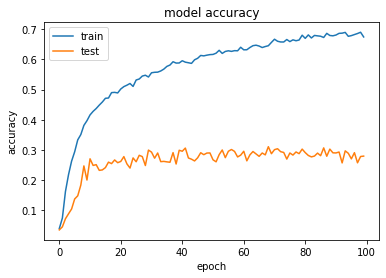

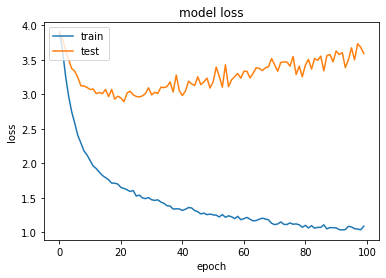

In [33]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

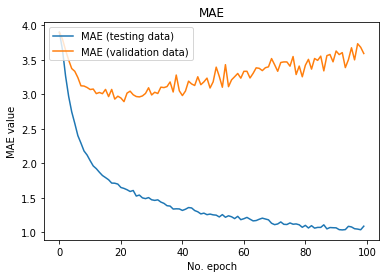

In [34]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (testing data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

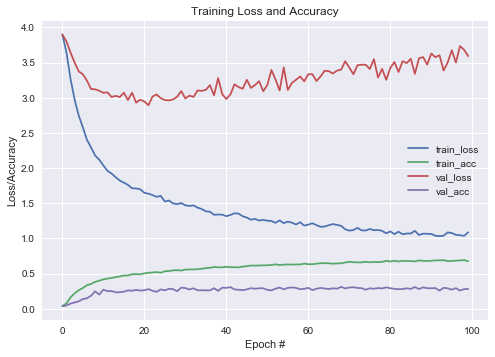

In [36]:
import matplotlib.pyplot as plt

N = np.arange(0, len(history.history['loss']))

# You can chose the style of your preference
# print(plt.style.available) to see the available options
plt.style.use("seaborn")

# Plot train loss, train acc, val loss and val acc against epochs passed
plt.figure()
plt.plot(N, history.history['loss'], label = "train_loss")
plt.plot(N, history.history['accuracy'], label = "train_acc")
plt.plot(N, history.history['val_loss'], label = "val_loss")
plt.plot(N, history.history['val_accuracy'], label = "val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
# Make sure there exists a folder called output in the current directory
# or replace 'output' with whatever direcory you want to put in the plots
plt.show()
plt.savefig('../Output/EpochVGG16.png')
plt.close()